In [1]:
from convert_user_inputs import convert_user_input, create_observer_structure, create_datasets
from ai_backend.loggers.model_logger import is_min
from input_mapping.metric_mapping import get_multilabel_metrics_by_names, get_classwise_metrics_by_names
from uuid import uuid4
import torch.nn as nn
from torch.optim import Adam, AdamW
import torch
import json
import wandb
import optuna
import joblib
import argparse
from datetime import datetime
import os
import re
import tqdm
from ai_backend.evaluators.metrics.multi_label_metrics import  multi_label_f_beta, multi_label_confusion_matrix, multi_label_accuracy, multi_label_precision, multi_label_recal
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt

c:\Users\elyes\miniconda3\envs\ird_deep_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_key = 'resnet18'
transform_type = 'standard'
batch_size = 128
lr = 0.00009354747253832916
epochs = 70
dataset_name = '2024-02-23-13-31-39'
dataset_path = f'datasets/{dataset_name}'

In [3]:

#read in json file with the label columns
dataset_config_path  = f'{dataset_path}/dataset_config.json'
train_dataset_path = f'{dataset_path}/All_train.csv'
validation_dataset_path = f'{dataset_path}/All_validation.csv'
test_dataset_path = f'{dataset_path}/All_test.csv'
with open(dataset_config_path) as json_file:
    dataset_config = json.load(json_file)
label_cols = dataset_config['label_names']
path_to_img_column = dataset_config['path_to_img_column']
#read wandb config

#initialize wand
train_dataset, validation_dataset, test_dataset = create_datasets(model_key = model_key, transform_type = transform_type,train_dataset_path = train_dataset_path,
                                                                   validation_dataset_path = validation_dataset_path,
                                                                   test_dataset_path = test_dataset_path, path_to_img_column = path_to_img_column,
                                                                     label_cols = label_cols, augmentation = True, shuffle = True)


In [4]:
#initialize the model
model, train_loader, validation_loader, test_dataloader, n_classes, model_dataset_config = convert_user_input(model_key = model_key, train_dataset=train_dataset, validation_dataset=validation_dataset, test_dataset=test_dataset,
                                                                                                                   dataset_path = dataset_path, augmentation = True,  pretrained = True, shuffle=True, lr=lr,
                                                                                                                   batch_size = batch_size, transform_type = transform_type)

In [5]:
#add dropout forward hooks to the model
for name, module in model.named_modules():
    re_pattern = re.compile(r'^layer\d+$')
    if re_pattern.match(name) is not None:
        print('Adding forward hook for:', name)
        module.register_forward_hook(lambda module, input,
                                      output: torch.nn.functional.dropout2d(output, p=0.2, training=module.training))

Adding forward hook for: layer1
Adding forward hook for: layer2
Adding forward hook for: layer3
Adding forward hook for: layer4


In [6]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [7]:
#train the model
best_model_save_folder = f'best_models_for_dataset/{dataset_name}/{model_key}/best_model_best_model_{transform_type}'
best_model_save_path = f'{best_model_save_folder}/best_model.pt'
os.makedirs(best_model_save_folder, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
progress_bar = tqdm.tqdm(range(epochs))
validation_loss_criterion = nn.BCEWithLogitsLoss()
validation_losses = []
best_validation_loss = np.inf
#move the model to the device
model.to(device)
#only run training if no model has been saved yet
if not os.path.exists(best_model_save_path):
    for epoch in progress_bar:
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            validaton_outputs = []
            validaton_labels = []
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                validaton_outputs.append(outputs)
                validaton_labels.append(labels)
            #concatenate the outputs and labels
            validaton_outputs = torch.cat(validaton_outputs, dim=0)
            validaton_labels = torch.cat(validaton_labels, dim=0)
            loss_validation = validation_loss_criterion(validaton_outputs, validaton_labels).item()
            if is_min(loss_validation, best_validation_loss):
                best_validation_loss = loss_validation
                torch.save(model.state_dict(), best_model_save_path)
            validation_losses.append(loss_validation)
            #update the progress bar
            progress_bar.set_postfix({'Loss validation': loss_validation, 'best validation loss': min(validation_losses)})
        

  0%|          | 0/70 [00:00<?, ?it/s]

In [8]:
#load the best model
model.load_state_dict(torch.load(best_model_save_path))

<All keys matched successfully>

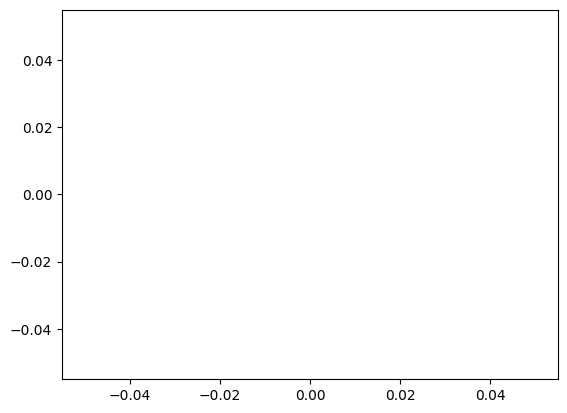

In [9]:
#plot the loss
plt.plot(validation_losses)

In [10]:
#get the predictions for the model
y_true_validation = []
y_pred_validation = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true_validation.append(labels.detach().clone())
        y_pred_validation.append(outputs.detach().clone())
y_true_validation = torch.cat(y_true_validation, dim=0).cpu()
y_pred_validation = torch.cat(y_pred_validation, dim=0).cpu()

In [11]:
#find the best threshold for each label
#turn off optuna warnings
step_size = 0.01
iterations = 1/step_size
#set the verbosity to error

best_thresholds = []

for i in range(len(label_cols)):
    best_thresholds.append(0)
    best_score = 0
    #todo fix the max function
    for j in range(int(iterations)):
        threshold = j*step_size
        f1_score = multi_label_f_beta(y_true_validation, y_pred_validation, beta=1.0, averaging_type=None, threshold=threshold)
        if f1_score[i] > best_score:
            best_score = f1_score[i]
            best_thresholds[i] = threshold
    print('Best thresholds found for class', label_cols[i], 'at', best_thresholds[i], 'with a score of', best_score)
#save the best thresholds
model_config = {
    'best_thresholds': best_thresholds
}

best_thresholds = torch.Tensor(best_thresholds)



c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: in

Best thresholds found for class Age-related Macular Degeneration at 0.1 with a score of 0.7435897435897436
Best thresholds found for class Best Disease at 0.08 with a score of 1.0


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:142: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:142: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:142: RuntimeWarning: invalid value encountered in div

Best thresholds found for class Bietti crystalline dystrophy at 0.14 with a score of 1.0
Best thresholds found for class cataract at 0.8 with a score of 0.983050847457627


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: in

Best thresholds found for class Cone Dystrophie or Cone-rod Dystrophie at 0.06 with a score of 0.6666666666666666
Best thresholds found for class Diabetic Retinopathy at 0.58 with a score of 0.8666666666666666


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: in

Best thresholds found for class glaucoma at 0.46 with a score of 0.8070175438596492
Best thresholds found for class Maculopathy at 0.9400000000000001 with a score of 0.8235294117647058


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:142: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:142: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in div

Best thresholds found for class Myopia at 0.73 with a score of 0.9333333333333333
Best thresholds found for class Normal at 0.67 with a score of 0.736842105263158


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: in

Best thresholds found for class Retinitis Pigmentosa at 0.67 with a score of 0.9302325581395349
Best thresholds found for class Stargardt Disease at 0.03 with a score of 0.6666666666666666


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:142: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:142: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:172: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:142: RuntimeWarning: invalid value encountered in div

In [12]:
print('Best thresholds:', best_thresholds)
print(label_cols)

Best thresholds: tensor([0.1000, 0.0800, 0.1400, 0.8000, 0.0600, 0.5800, 0.4600, 0.9400, 0.7300,
        0.6700, 0.6700, 0.0300])
['Age-related Macular Degeneration', 'Best Disease', 'Bietti crystalline dystrophy', 'cataract', 'Cone Dystrophie or Cone-rod Dystrophie', 'Diabetic Retinopathy', 'glaucoma', 'Maculopathy', 'Myopia', 'Normal', 'Retinitis Pigmentosa', 'Stargardt Disease']


In [13]:
#execute the model on the test set
y_true = []
y_pred = []
x = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.detach().clone())
        y_pred.append(outputs.detach().clone())
        x.append(inputs.detach().clone())
y_true = torch.cat(y_true, dim=0).cpu()
y_pred = torch.cat(y_pred, dim=0).cpu()
X_test = torch.cat(x, dim=0).cpu()

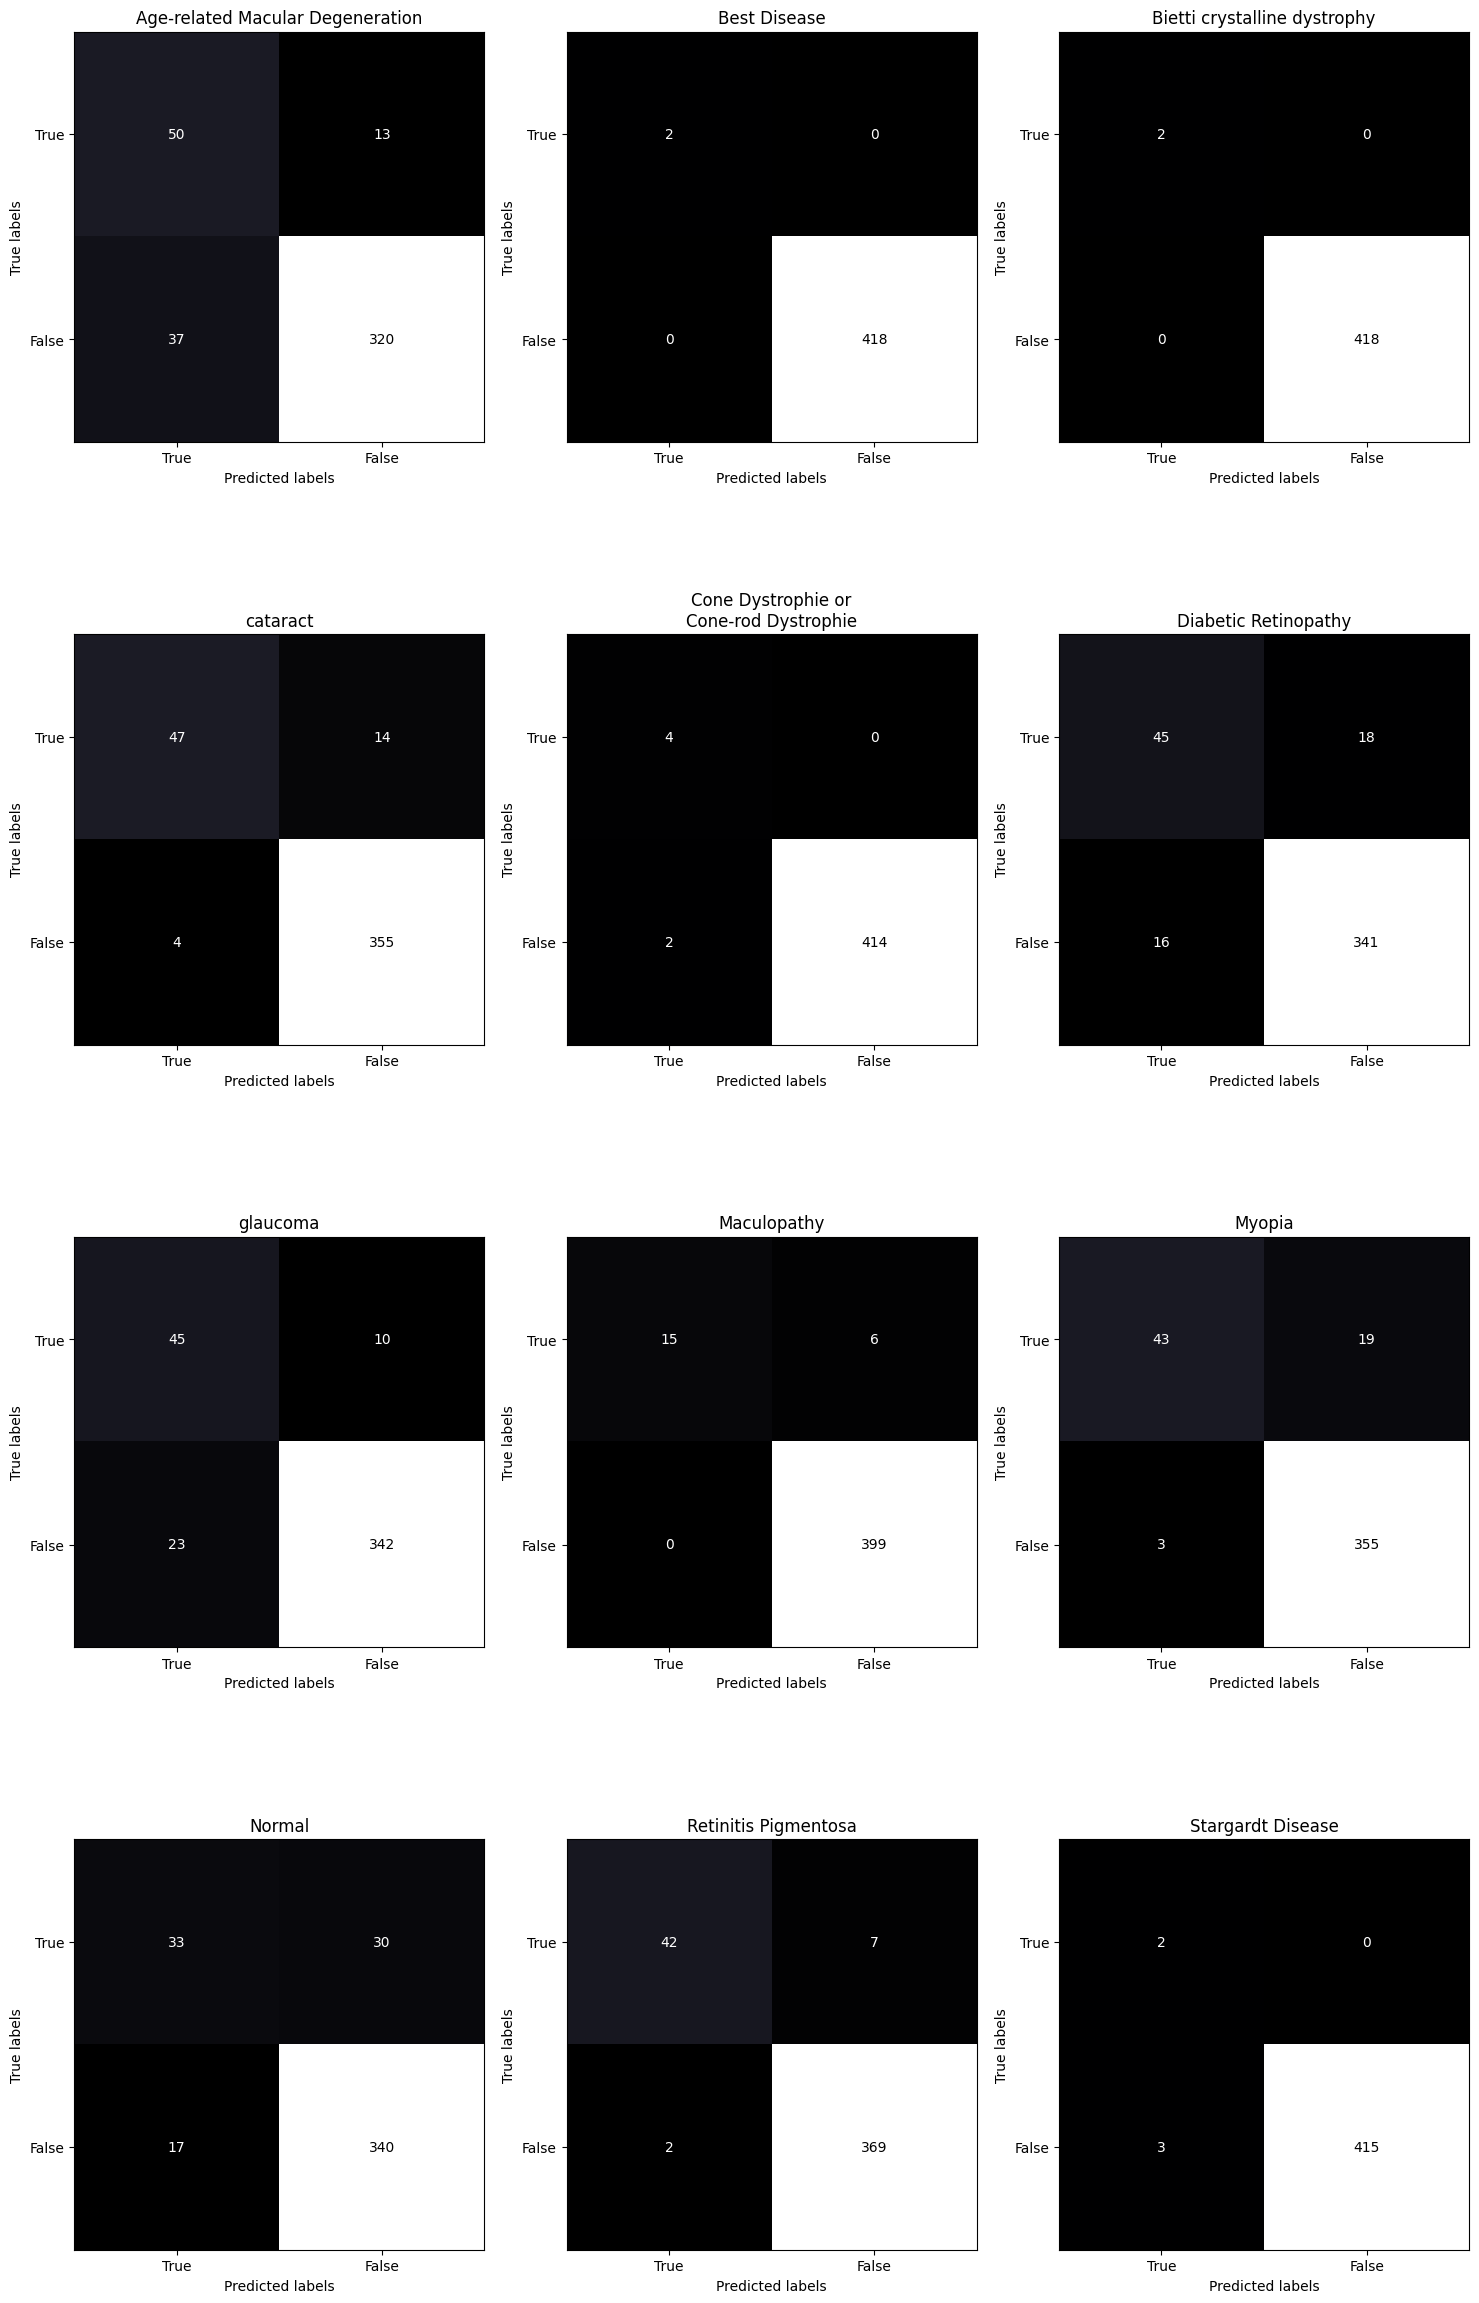

In [14]:
y_pred_cm = torch.sigmoid(y_pred) >best_thresholds
#calculate the confusion matrices on the test set
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
flipped_confusion_matrices = np.flip(confusion_matrices, axis=-1)
flipped_confusion_matrices = np.flip(flipped_confusion_matrices, axis=-2)
#plot the confusion matrices, one for each class, 3 per row
n_cols = 3
n_rows = int(np.ceil(len(train_dataset.classes) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_confusion_matrices[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = train_dataset.classes[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

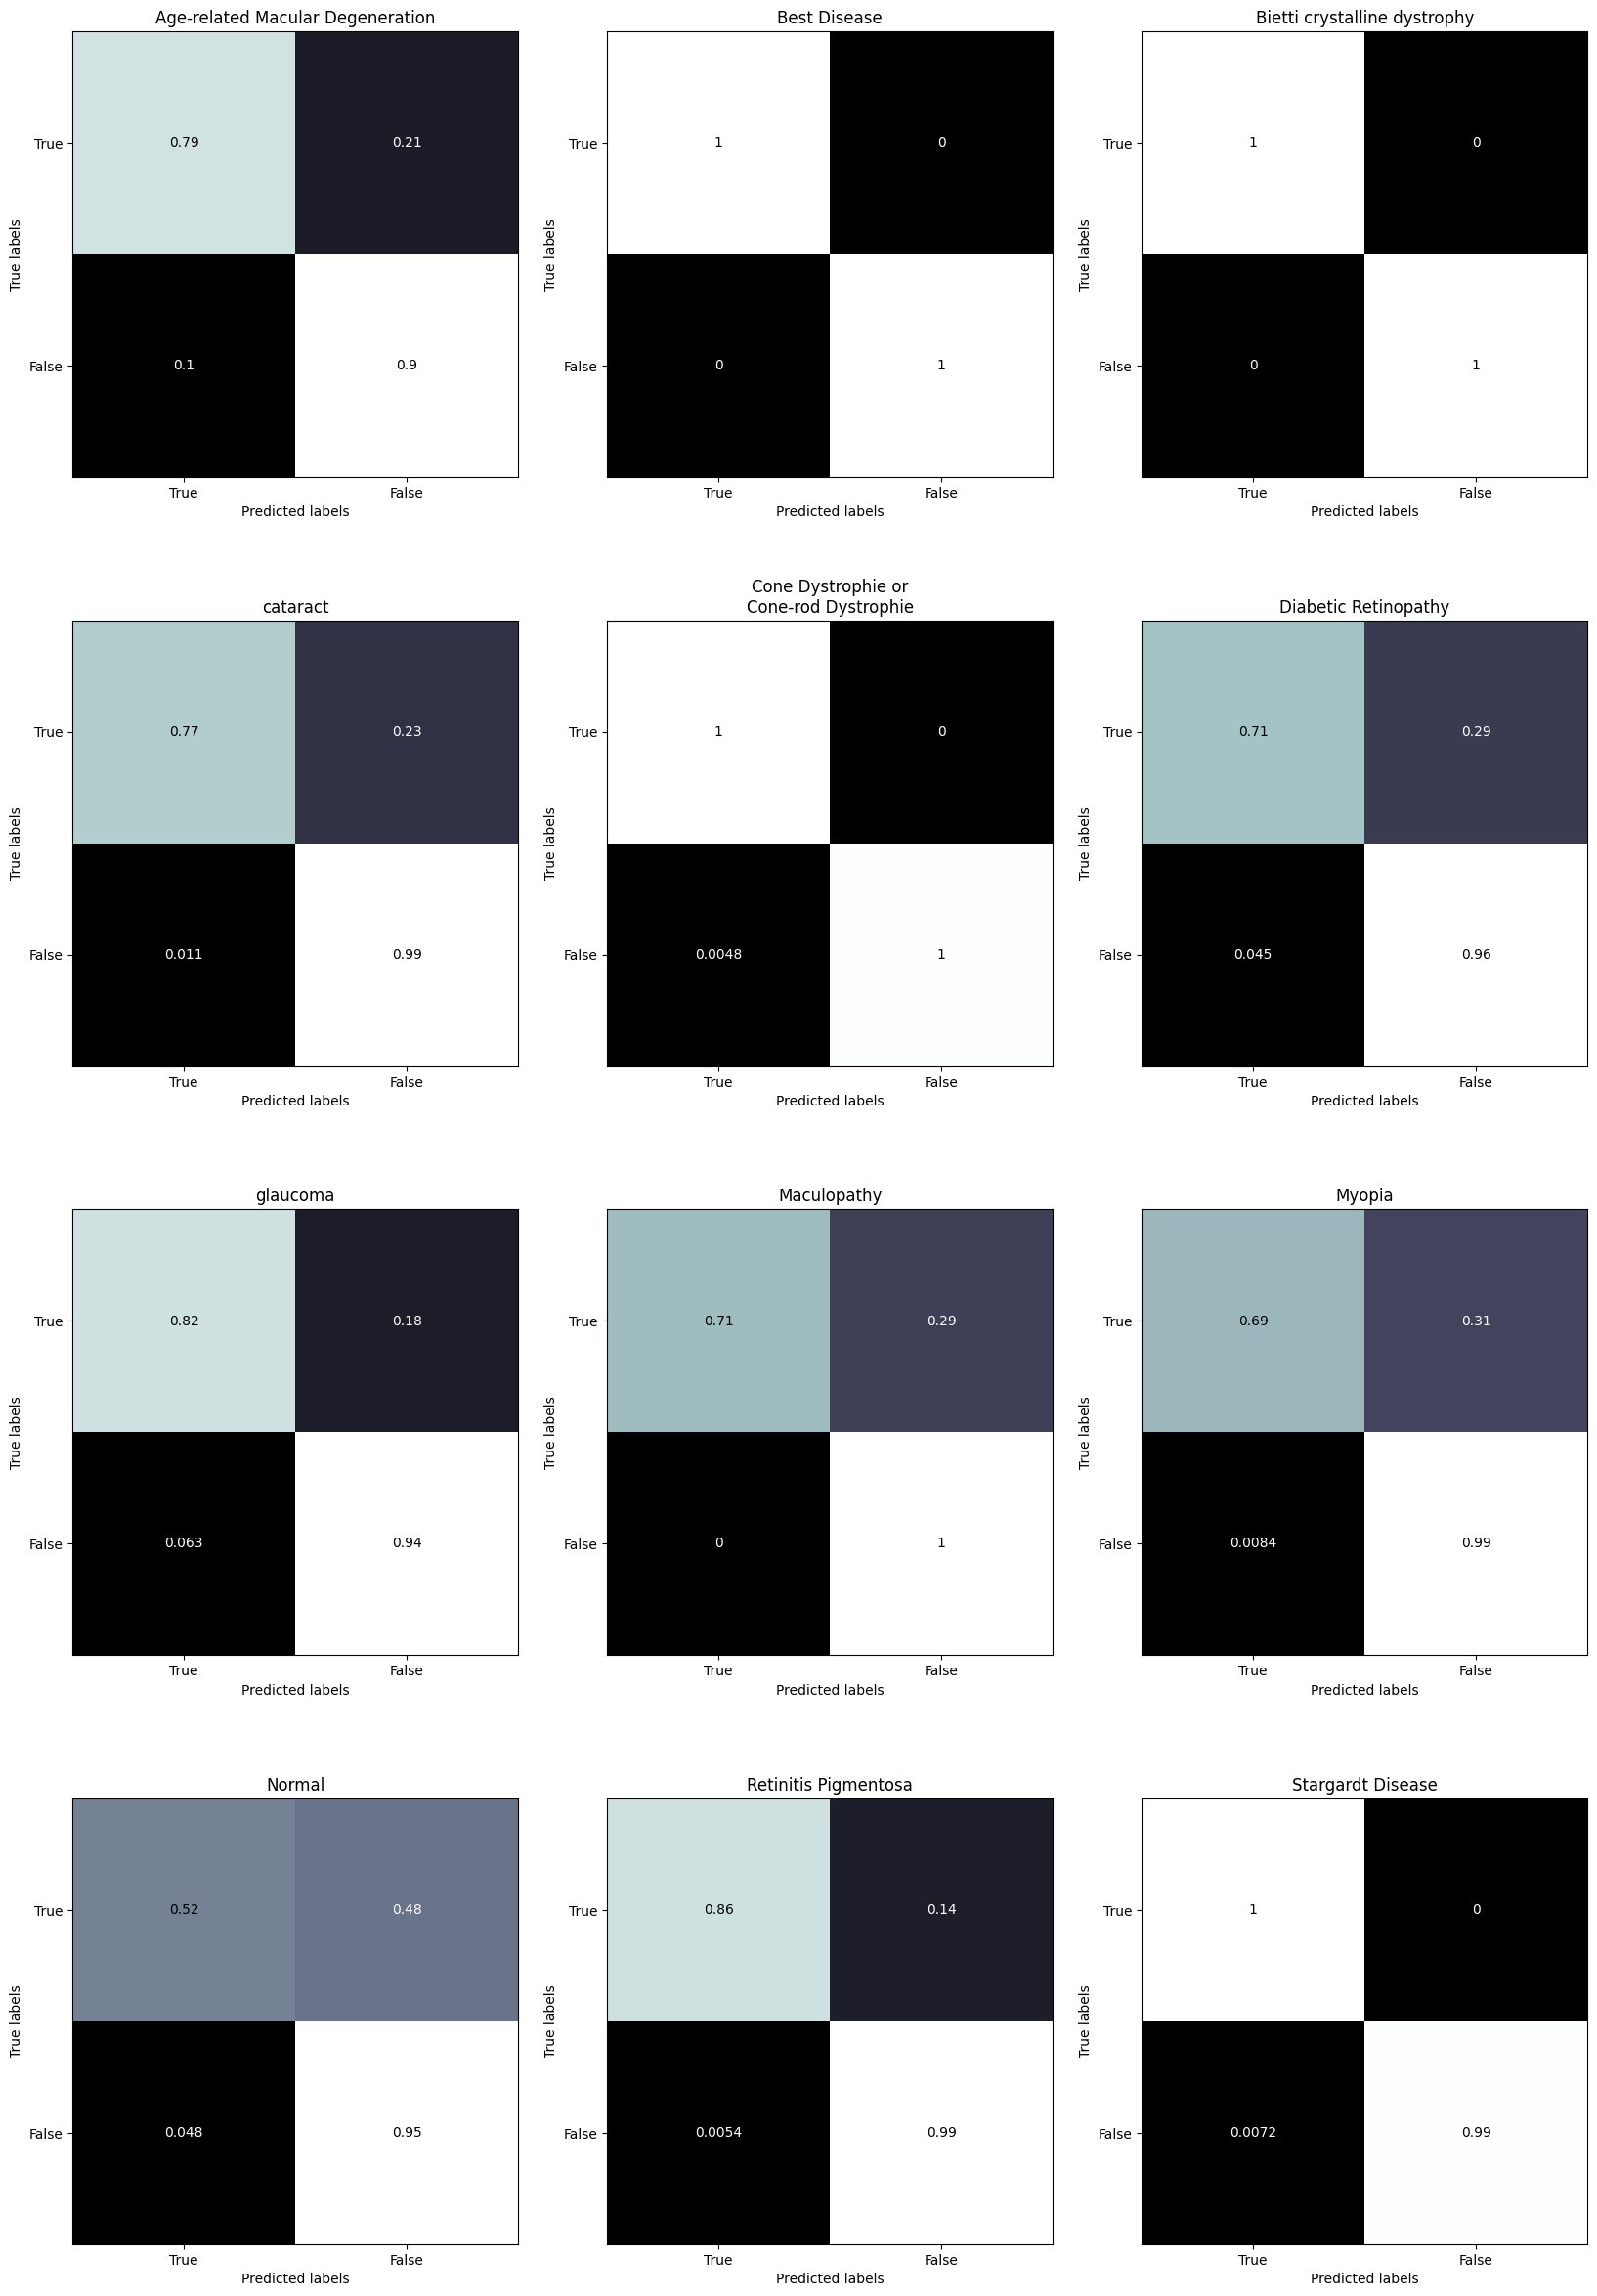

In [15]:
#plot the same confusion matrices with the row normalised values
cm_normalizer = confusion_matrices.sum(axis=2)#[:,np.newaxis]
#add a new dimension to the normalizer
cm_normalizer = cm_normalizer[:,np.newaxis]
#add a copy of the normalizer to the normalizer

#cm_normalizer = np.concatenate([cm_normalizer, cm_normalizer], axis=0)
reversed_normalizer = np.flip(cm_normalizer, axis=-1)
cm_normalizer=np.concatenate([cm_normalizer, reversed_normalizer], axis=1)
#flip the normalizer
cm_normalizer[:,:,1] = cm_normalizer[:,0,:]
normalised_cms = confusion_matrices / cm_normalizer
flipped_normalised_cms = np.flip(np.flip(normalised_cms, axis=-1), axis=-2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_normalised_cms[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = train_dataset.classes[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

tensor(63)
tensor(2)
tensor(2)
tensor(61)
tensor(4)
tensor(63)
tensor(55)
tensor(21)
tensor(62)
tensor(63)
tensor(49)
tensor(2)


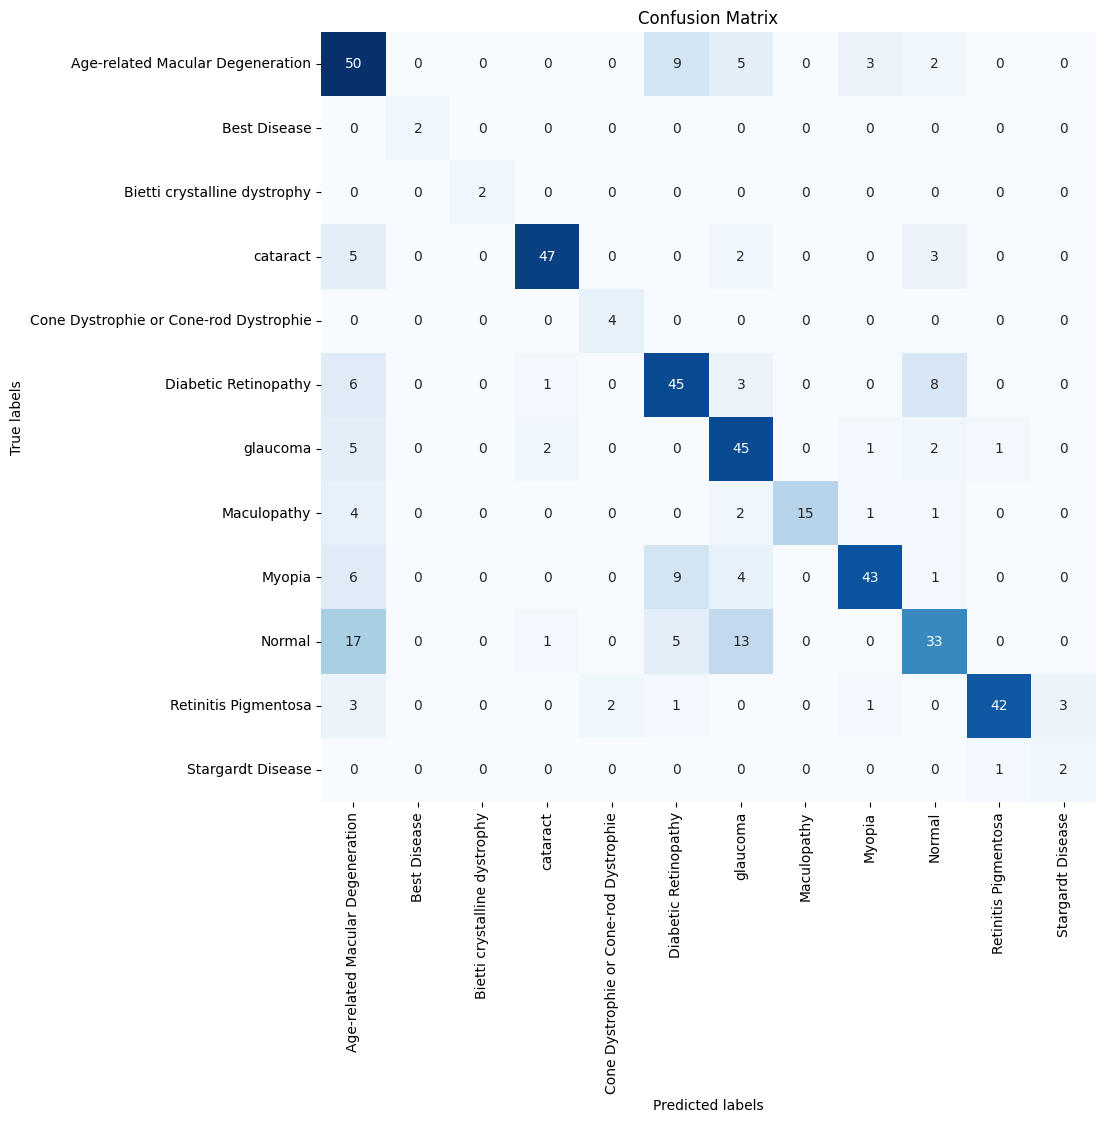

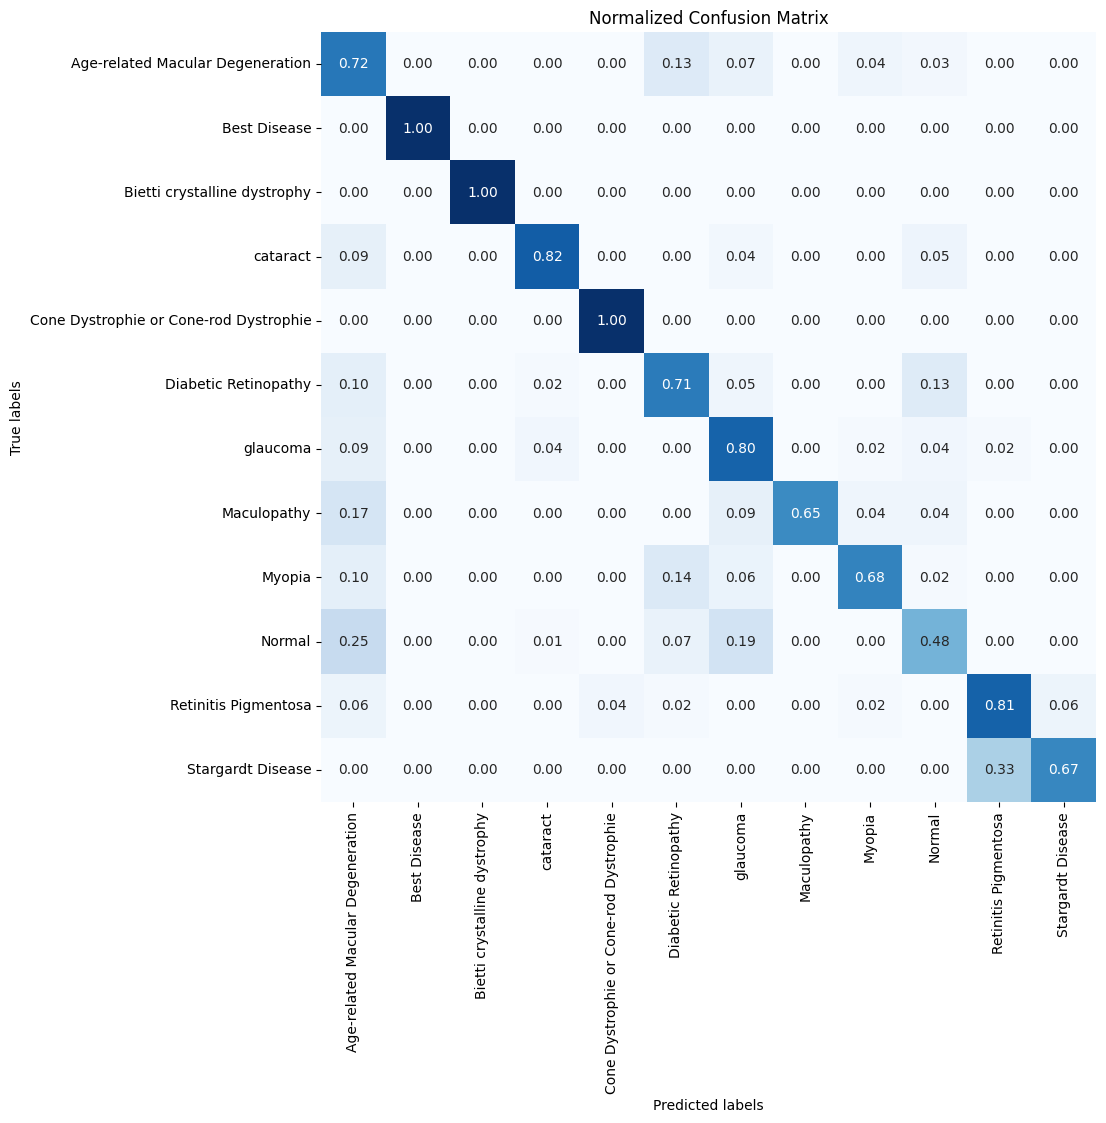

In [16]:
#generate a n_classes x n_classes matrix
#initialize the matrix
import seaborn as sns
confusion_matrix = np.zeros((n_classes, n_classes))
for i in range(n_classes):
    #find all the indexes where the true label is i
    indexes = y_true[:, i] == 1
    #sum the indexes
    print(indexes.sum())
    #find the predicted labels
    predicted_labels = y_pred_cm[indexes]
    confusion_matrix[i] = predicted_labels.sum(dim=0)
#plot the confusion matrix
# Using seaborn for a visually appealing heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, fmt='g',
             cmap='Blues', xticklabels=label_cols, yticklabels=label_cols, ax=ax, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
#do the same with normalized confusion matrix
#normalize the confusion matrix
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
#plot the confusion matrix
# Using seaborn for a visually appealing heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, fmt='.2f',
             cmap='Blues', xticklabels=label_cols, yticklabels=label_cols, ax=ax, cbar=False)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [45]:
#find the data points that have two or more labels
indexes = y_true.sum(dim=1) > 1
multilabel_examples = y_true[indexes]
print(multilabel_examples)
#get the idxs of the multilabel examples
multilabel_idxs = torch.where(multilabel_examples ==  1)
print(multilabel_idxs)
#create a label name array
print(label_cols)
multi_label_dict = {i.item() : [] for i in multilabel_idxs[0]}
for idx, label_idx in zip(multilabel_idxs[0], multilabel_idxs[1]):
    multi_label_dict[idx.item()].append(label_cols[label_idx.item()])
print(multi_label_dict)

tensor([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0

In [46]:
#show how many tp, fp, tn, fn there are in total
tp = confusion_matrices[:, 1, 1]
fp = confusion_matrices[:, 0, 1]
tn = confusion_matrices[:, 0, 0]
fn = confusion_matrices[:, 1, 0]
print(f'TP: {tp.sum()}')
print(f'FP: {fp.sum()}')
print(f'TN: {tn.sum()}')
print(f'FN: {fn.sum()}')
print('-----------------------------------')
best_thresholds = np.array(best_thresholds)
#calculate the precision, recall, accuracy and f1 score
precision = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
recall = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
accuracy = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
f1 = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='macro', threshold=best_thresholds)
print(f'Precision macro: {precision:.2f}')
print(f'Recall macro: {recall:.2f}')
print(f'Accuracy macro: {accuracy:.2f}')
print(f'F1 macro: {f1:.2f}')
print('-----------------------------------')
#do the same for the micro scores
precision = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
recall = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
accuracy = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
f1 = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='micro', threshold=best_thresholds)
print(f'Precision micro: {precision:.2f}')
print(f'Recall micro: {recall:.2f}')
print(f'Accuracy micro: {accuracy:.2f}')
print(f'F1 micro: {f1:.2f}')


TP: 330
FP: 107
TN: 4486
FN: 117
-----------------------------------
Precision macro: 0.79
Recall macro: 0.82
Accuracy macro: 0.96
F1 macro: 0.81
-----------------------------------
Precision micro: 0.76
Recall micro: 0.74
Accuracy micro: 0.96
F1 micro: 0.75


In [47]:
model.train()
all_dropout_predictions = []
#run the model on the test set with dropout enabled, 100 times
n_predictions = 100
prediction_progress_bar = tqdm.tqdm(range(n_predictions))
for i in prediction_progress_bar:
    y_test_dropout_predictions = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            y_test_dropout_predictions.append(outputs.detach().clone())
        y_test_dropout_predictions = torch.cat(y_test_dropout_predictions, dim=0).cpu()
        all_dropout_predictions.append(y_test_dropout_predictions)


100%|██████████| 100/100 [30:46<00:00, 18.46s/it]


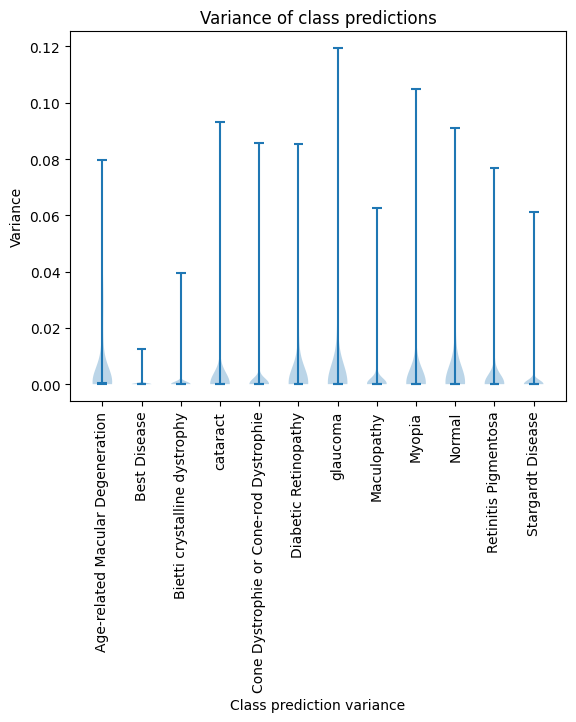

In [48]:
#calculate prediction proabilities by applying the sigmoid function to the predictions
all_dropout_predictions_proababilities = torch.sigmoid(torch.stack(all_dropout_predictions)) 
#convert the all_dropout_predictions to a numpy array
all_dropout_predictions_proababilities = all_dropout_predictions_proababilities.numpy()
#calculate the uncertainty of the predictions
probability_vectors = np.sum(all_dropout_predictions_proababilities, axis=0) / n_predictions
#calculate the uncertainty of the predictions
euclidean_distance = np.abs(all_dropout_predictions_proababilities - probability_vectors)**2
variance_in_predictions = np.var(all_dropout_predictions_proababilities, axis=0)
#violin plot of the entropy, x axis is the class, y axis is the entropy
fig, ax = plt.subplots()
ax.violinplot(variance_in_predictions, showmedians=True, points=500)
ax.set_title('Variance of class predictions')
ax.set_xlabel('Class prediction variance')
#make labels for the x axis
ax.set_xticks(np.arange(1, len(label_cols) +1))
ax.set_xticklabels(label_cols, rotation=90)
ax.set_ylabel('Variance')

plt.show()


Max entropy: 12.0


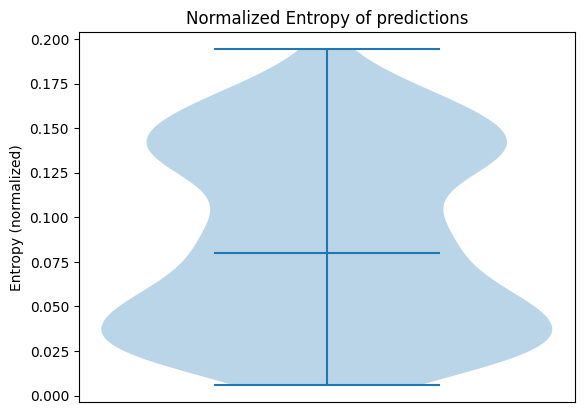

In [49]:
#calculate the entropy of the predictions
entropy = -np.sum(probability_vectors * np.log2(probability_vectors), axis=1)
max_entropy = -np.log2(0.5)*n_classes
entropy_normalized = entropy / max_entropy
print(f'Max entropy: {max_entropy}')
#plot the entropy
fig, ax = plt.subplots()
ax.violinplot(entropy_normalized, showmedians=True, points=500)
ax.set_title('Normalized Entropy of predictions')
#turn off the x axis
ax.set_xticks([])
ax.set_ylabel('Entropy (normalized)')
#ylim
#add ytick at the median entropy
plt.show()

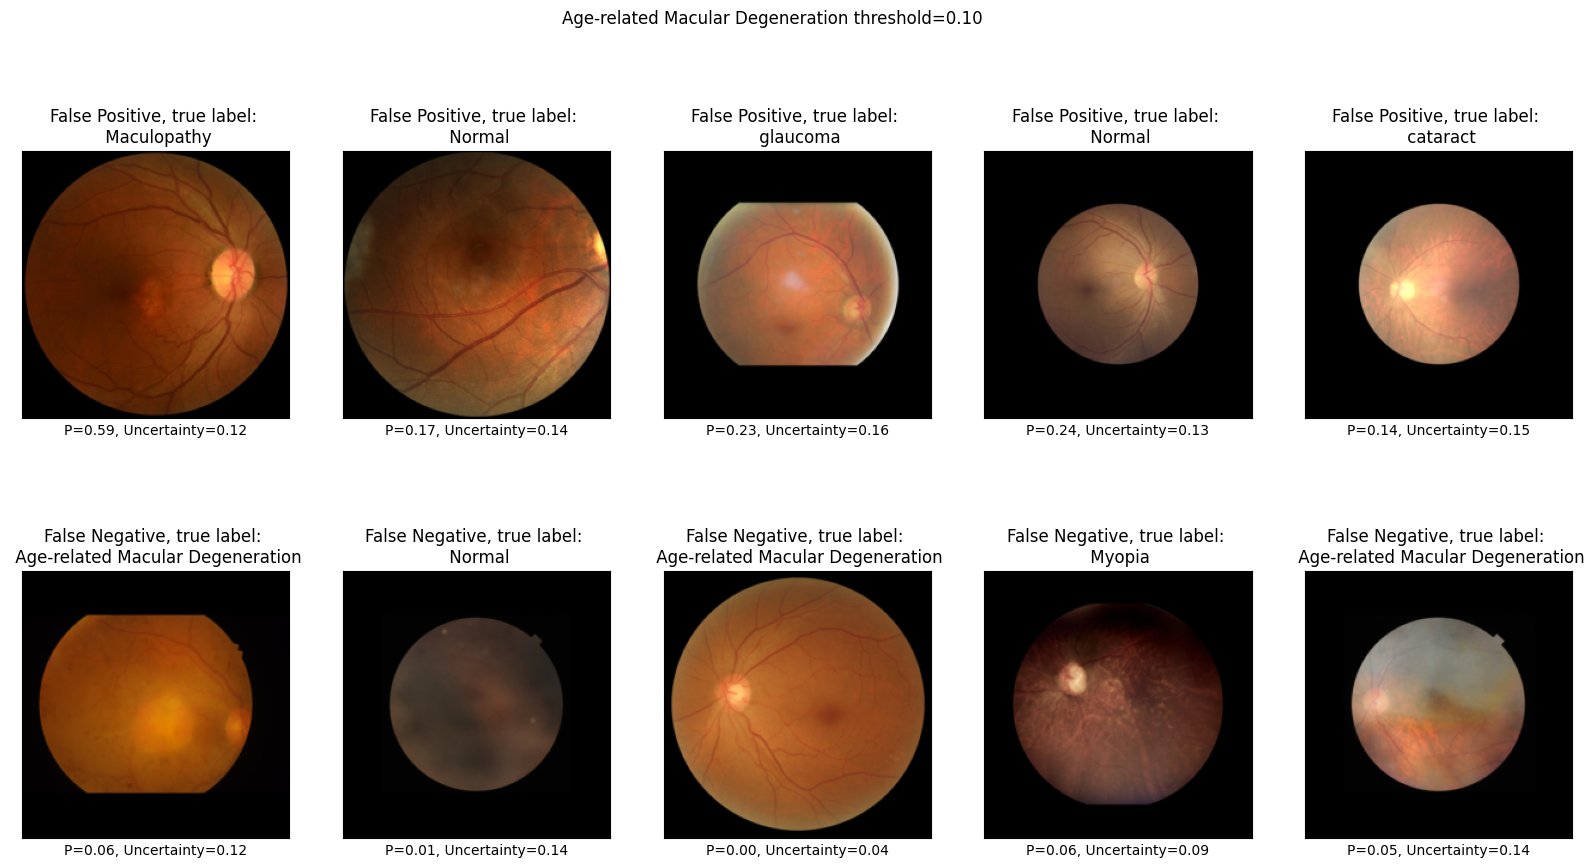

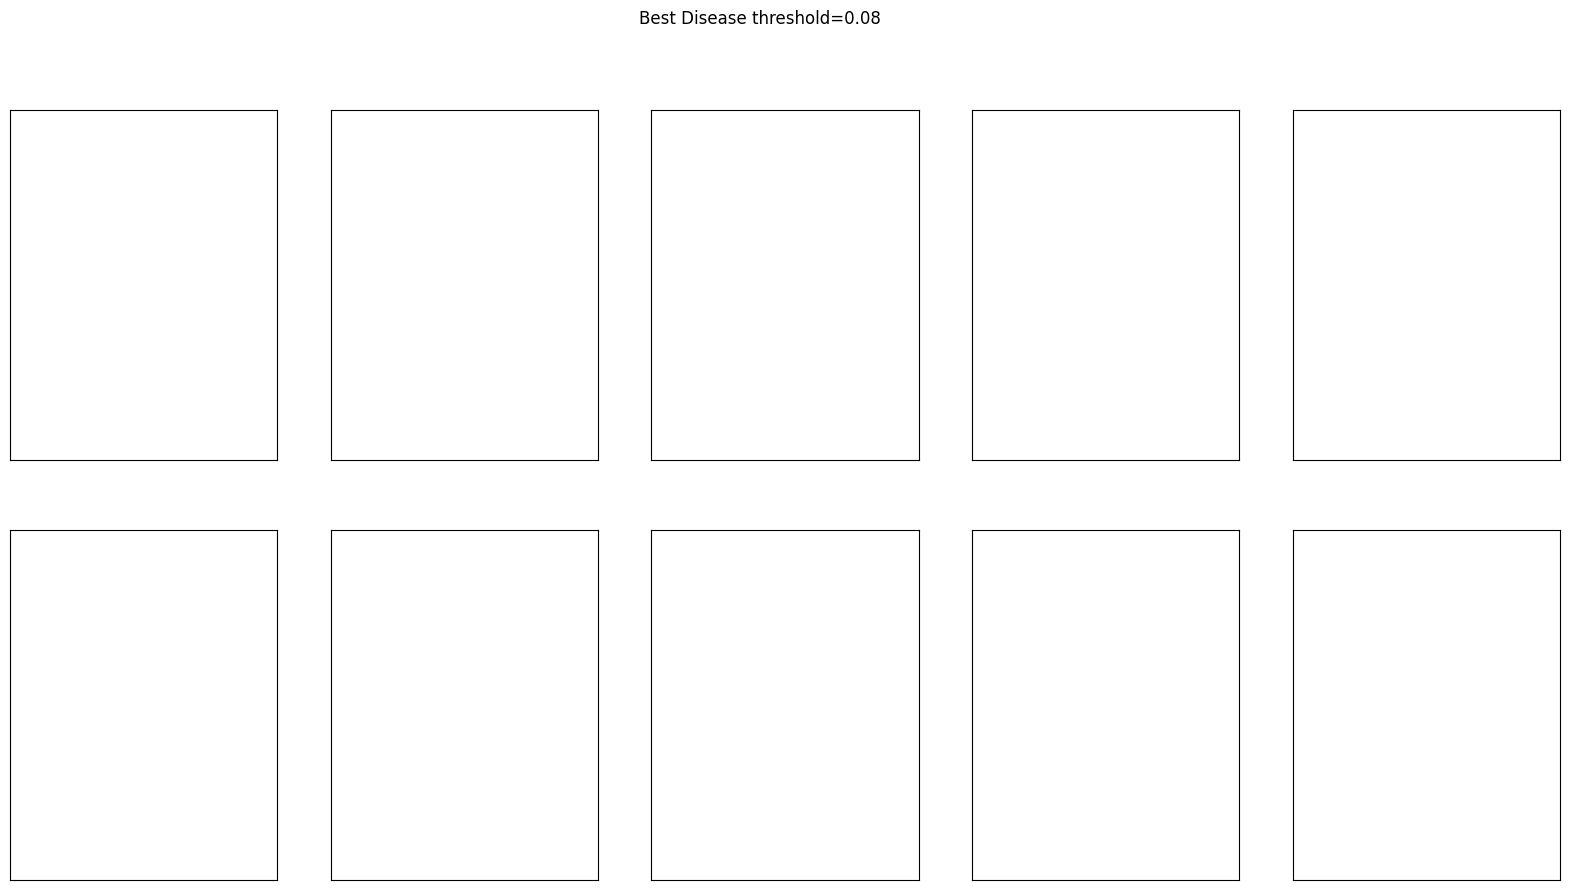

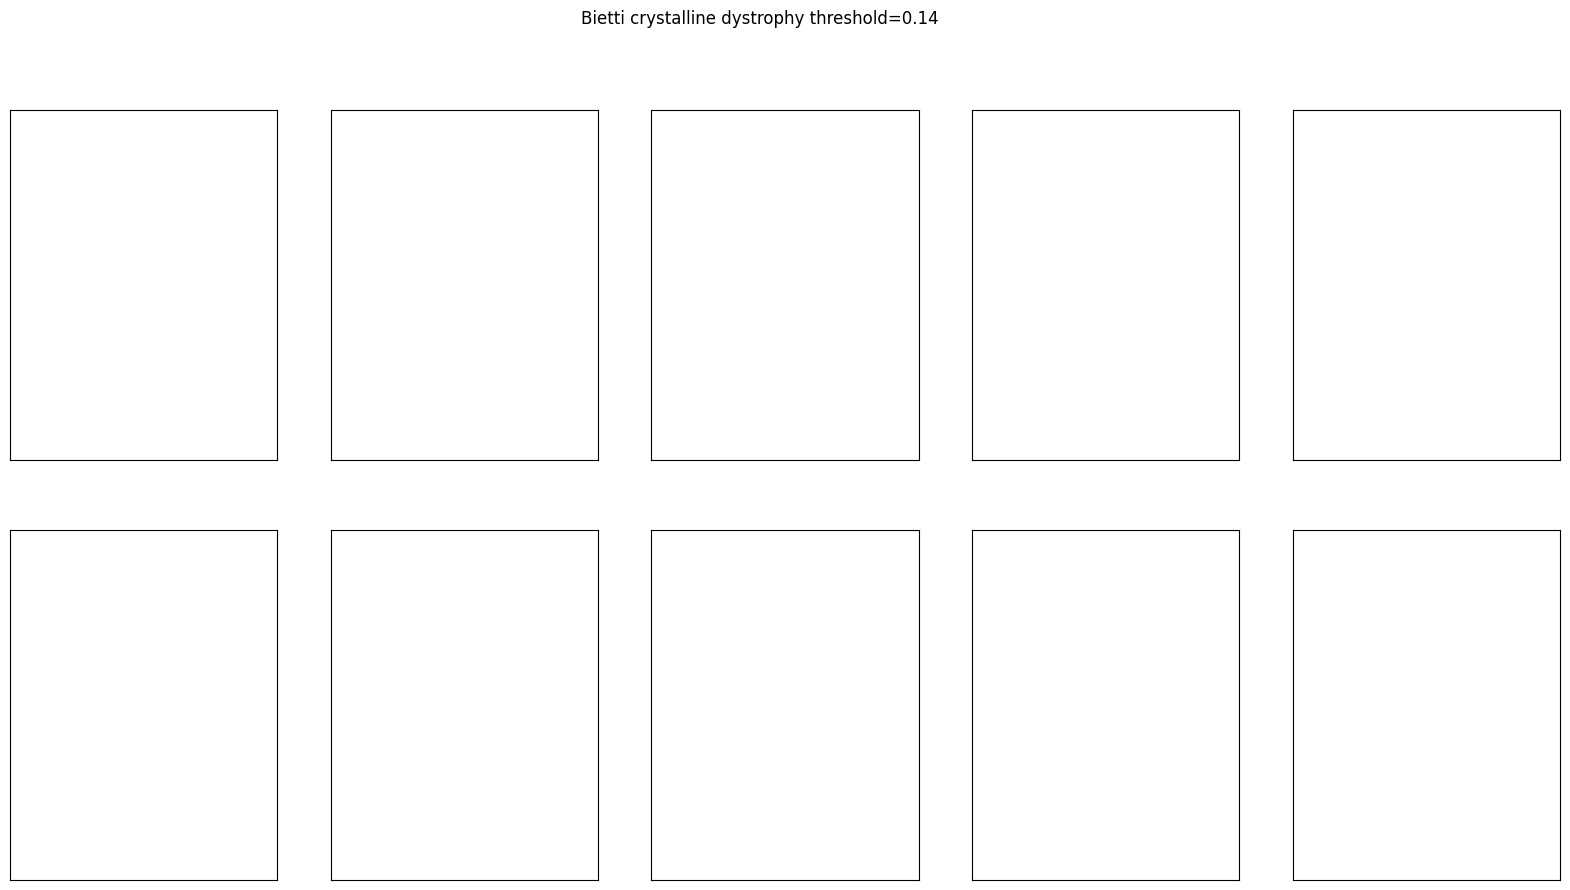

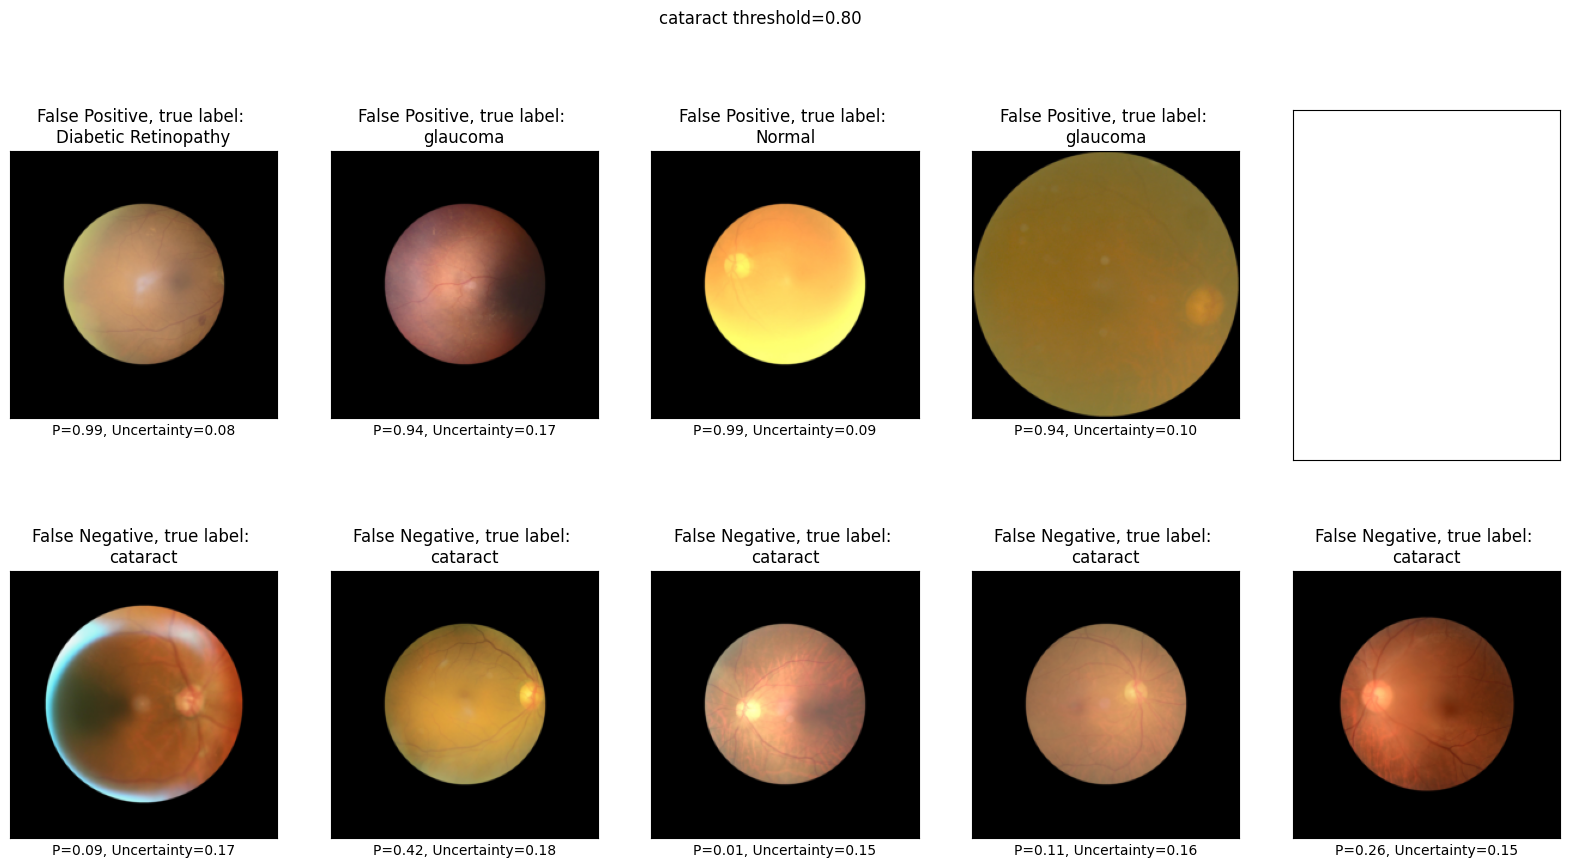

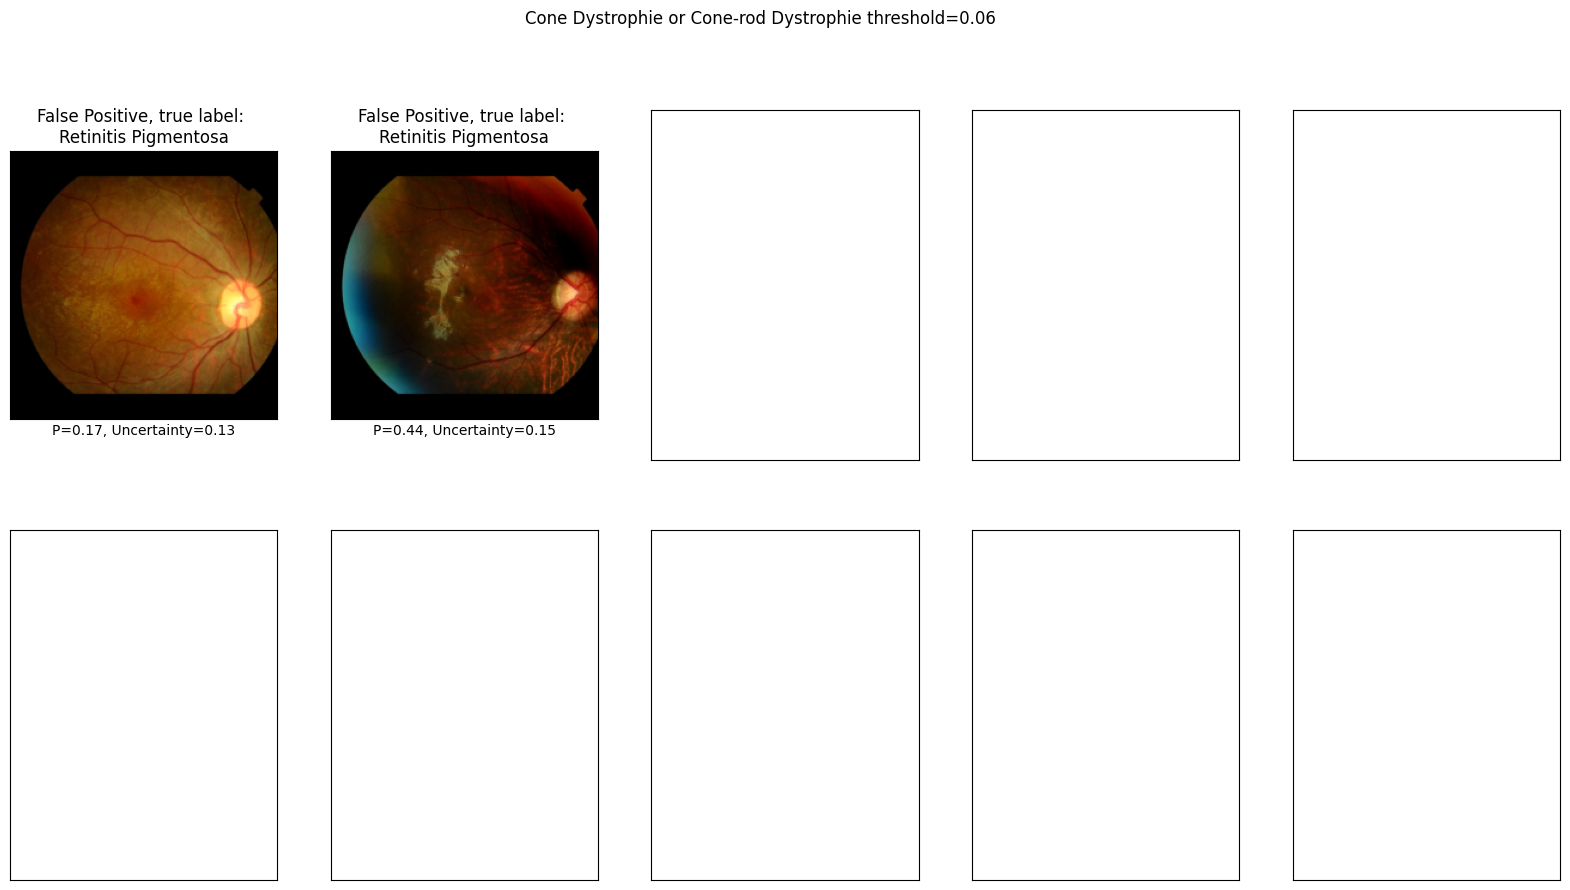

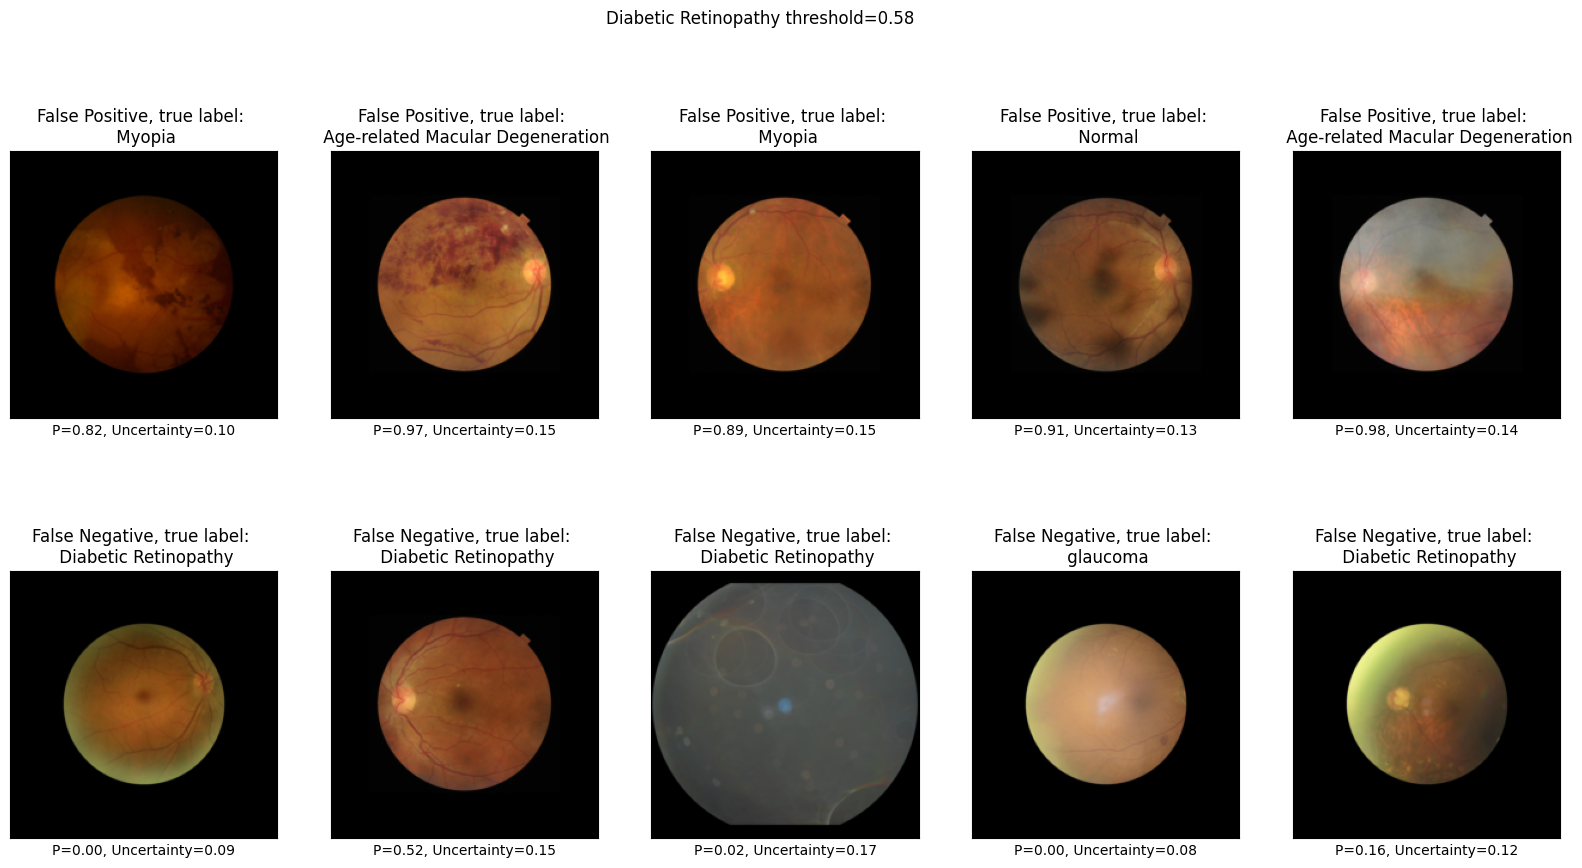

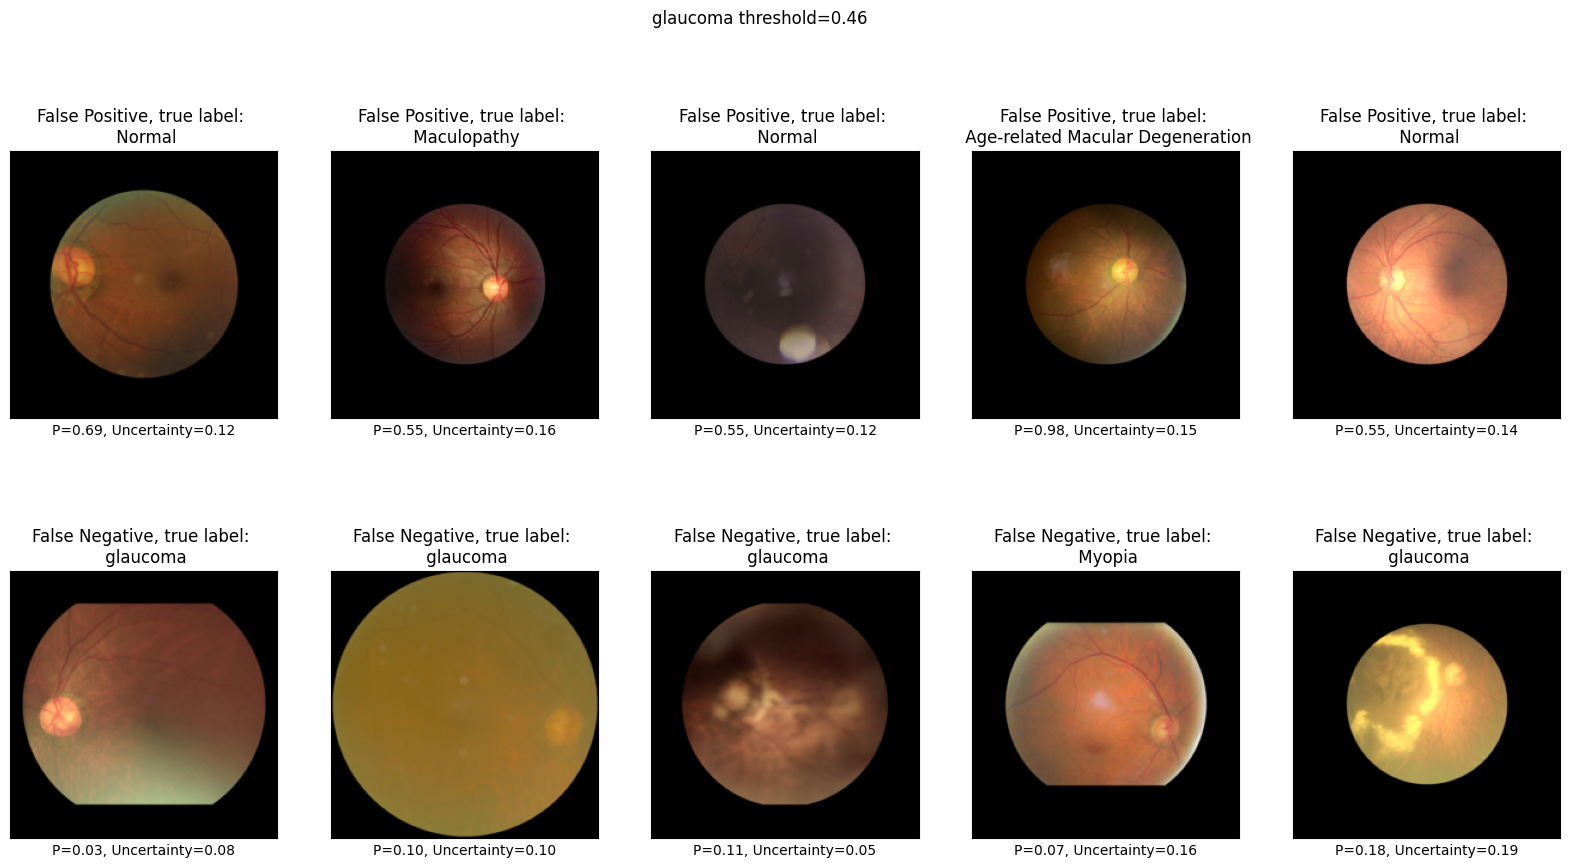

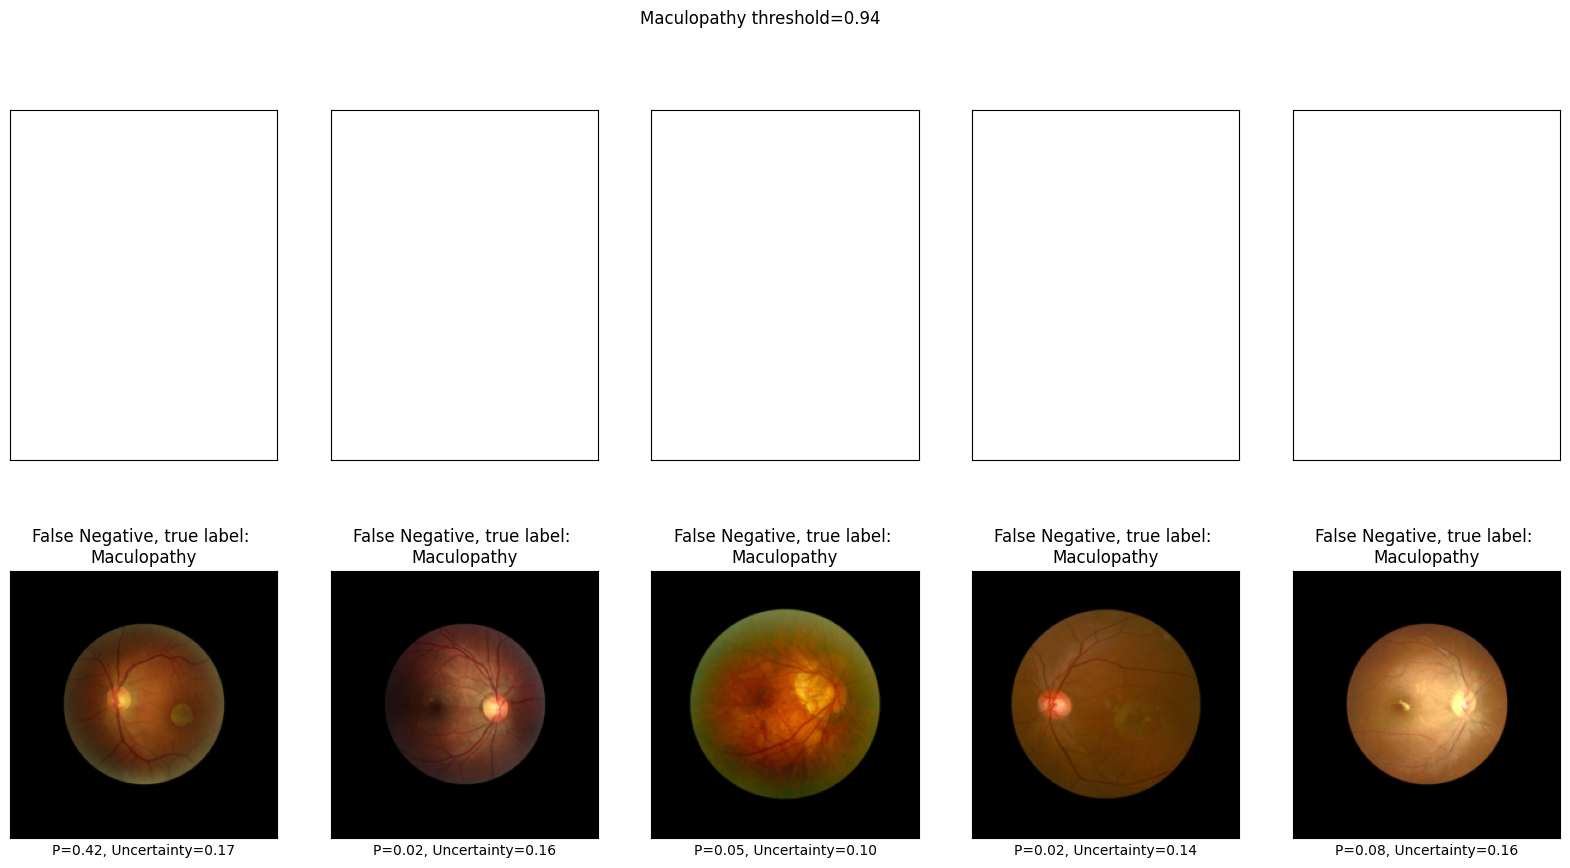

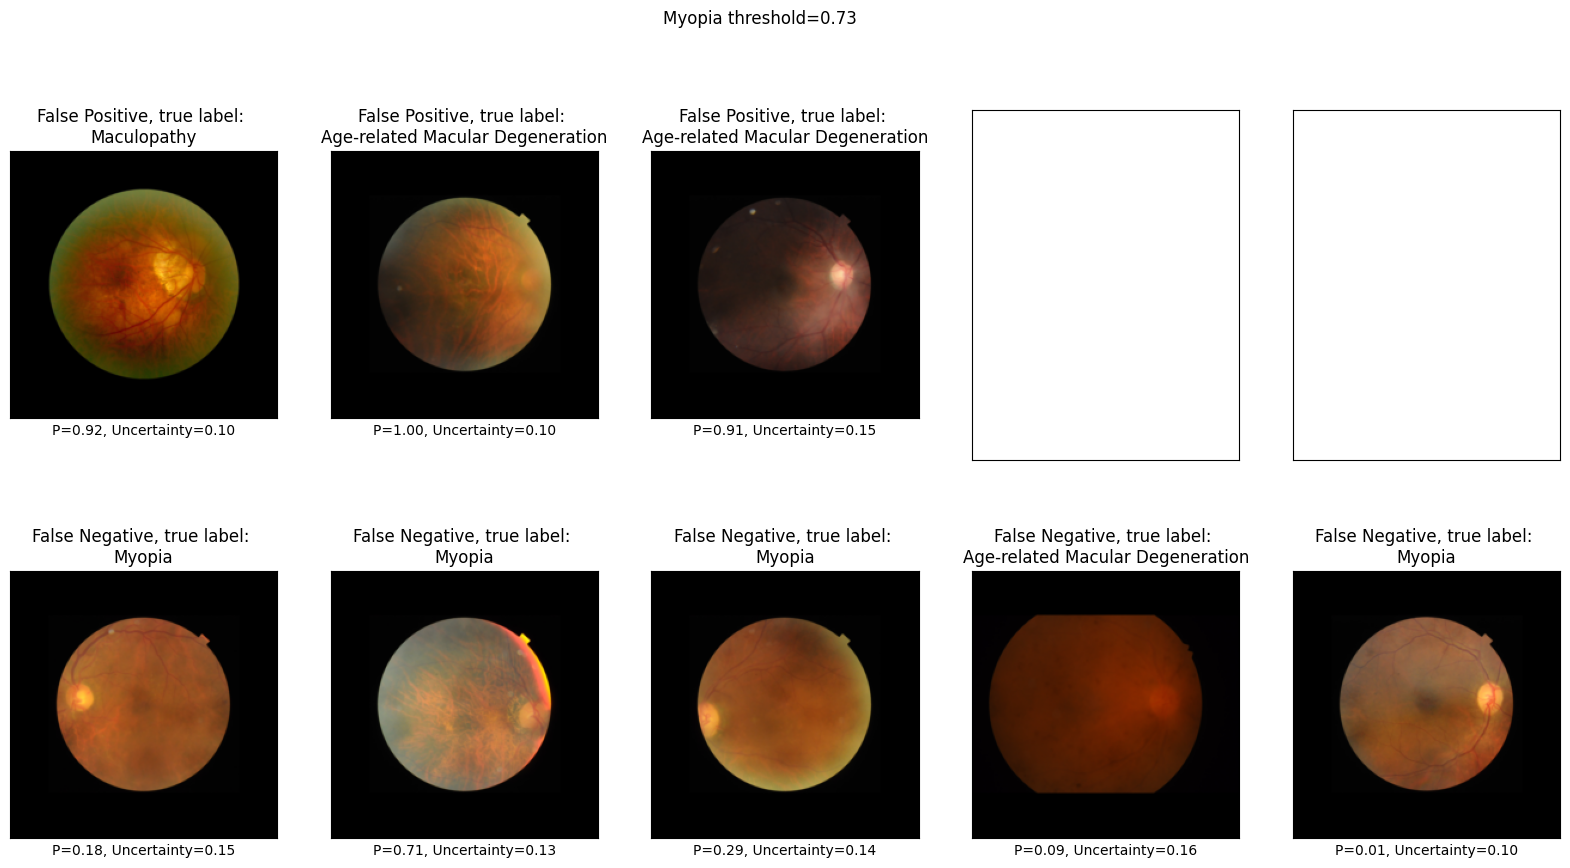

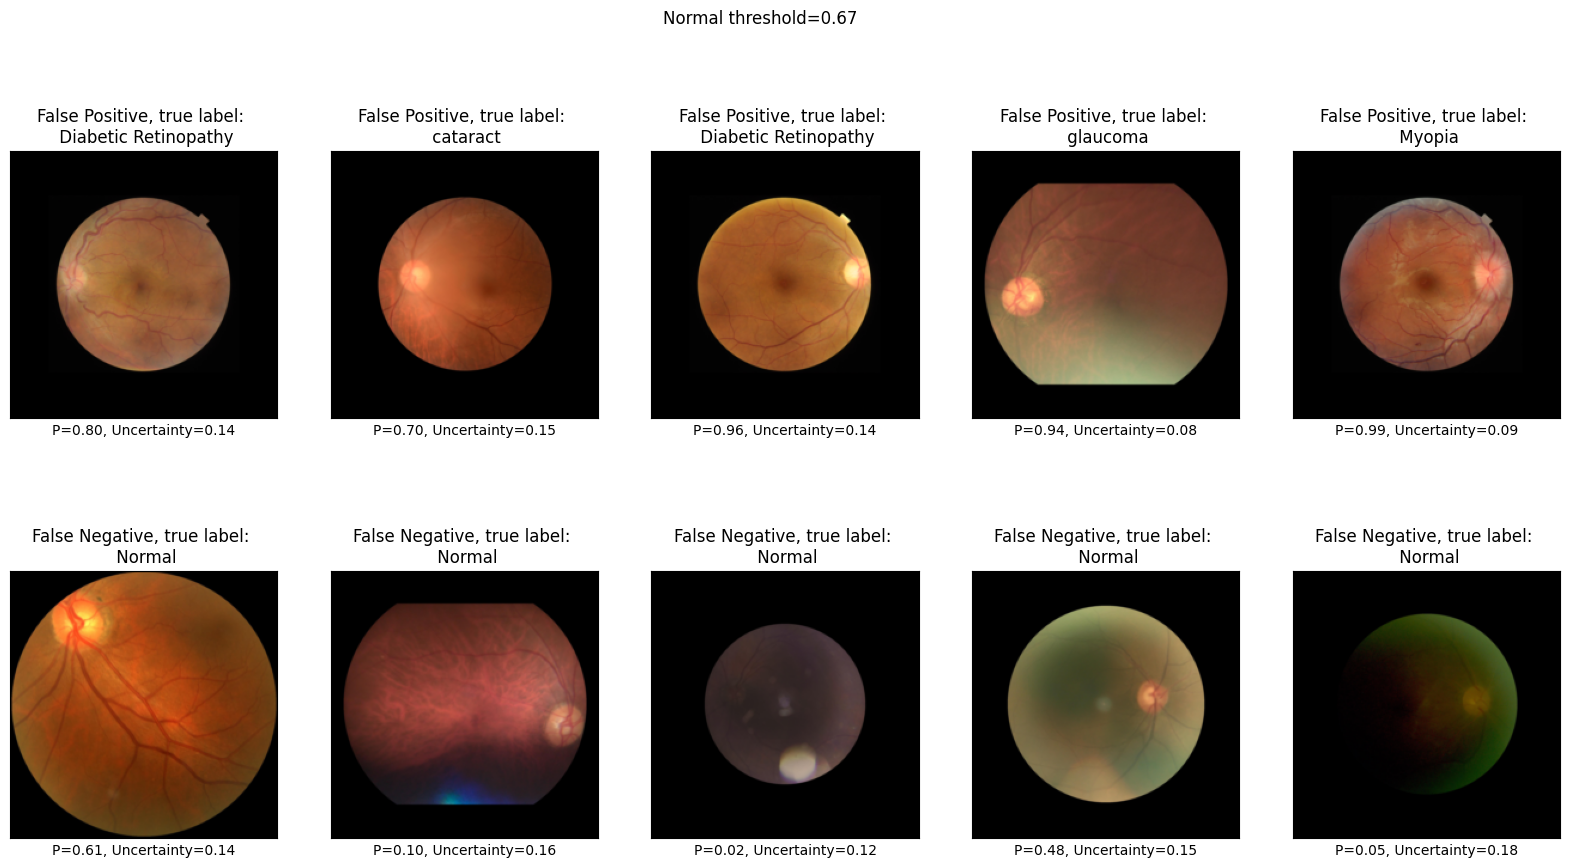

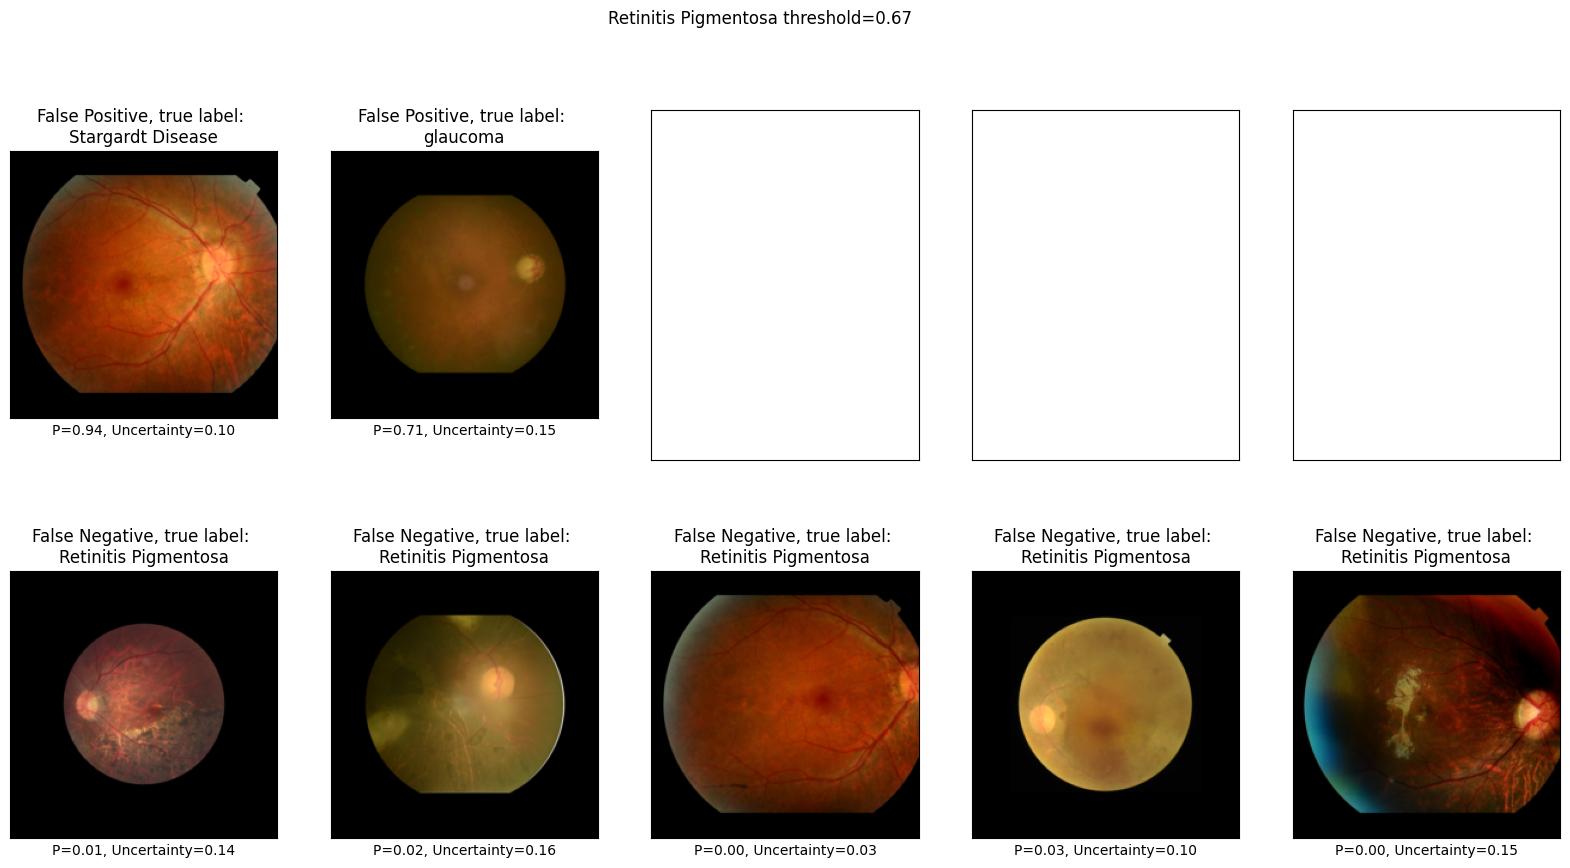

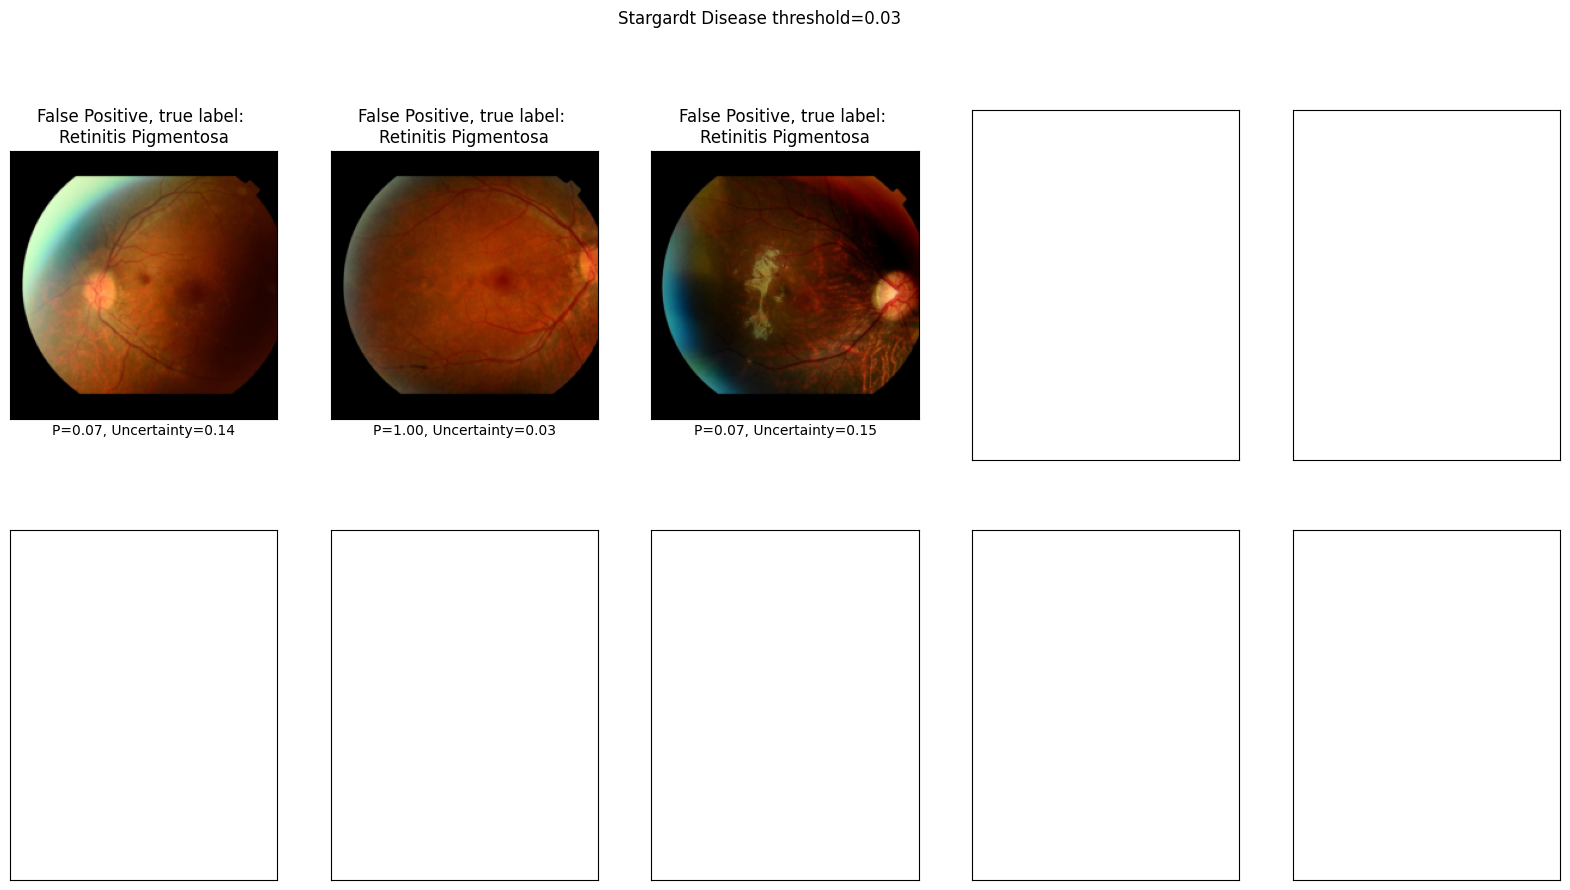

In [50]:
#result show that tthe wrong predictions have an entropy which is very close to the median entropy or higher
# Replace this with your actual data
all_train_dataset_classes = train_dataset.classes
n_categories_per_class = 2
n_images_per_category = 5
y_pred_prob = torch.sigmoid(y_pred)
all_fp_indices = set()
all_fn_indices = set()
for i, class_label in enumerate(all_train_dataset_classes):
    #filter the dataset to only images of the current class
    class_indices = torch.where(y_true[:, i] == 1)[0]
    #find the indices of the images which are fp and fn
    fp_indices = torch.where((y_true[:, i] == 0) & (y_pred_cm[:, i] == 1))[0]
    fn_indices = torch.where((y_true[:, i] == 1) & (y_pred_cm[:, i] == 0))[0]
    all_fp_indices.update(fp_indices)
    all_fn_indices.update(fn_indices)
    #get 5 random indices
    fp_indices = fp_indices[torch.randperm(len(fp_indices))[:5]].numpy()
    fn_indices = fn_indices[torch.randperm(len(fn_indices))[:5]].numpy()
    #get the images and labels from the test set
    fp_images = [X_test[i] for i in fp_indices]
    fn_images = [X_test[i] for i in fn_indices]
    fp_labels = [y_true[i] for i in fp_indices]
    fn_labels = [y_true[i] for i in fn_indices]
    #get the true labels
    fp_label_indices = torch.where(y_true[fp_indices, :] == 1)[1]
    fn_label_indices = torch.where(y_true[fn_indices, :] == 1)[1]
    #get the labels
    fp_labels = [label_cols[i] for i in fp_label_indices]
    fn_labels = [label_cols[i] for i in fn_label_indices]
    #split ax into 5 subplots
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()
    #turn off all axes ticks
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    
    #plot the false positives and false negatives
    #check if fp and fn images have the same length
    if len(fp_images) >= 5 and len(fn_images) >= 5:
        for j, (fp_image, fn_image) in enumerate(zip(fp_images, fn_images)):
            axes[j].imshow(fp_image.permute(1, 2, 0))
            axes[j].set_title(f'False Positive, true label: \n {(fp_labels[j])}')
            axes[j+5].imshow(fn_image.permute(1, 2, 0))
            axes[j+5].set_title(f'False Negative, true label: \n {fn_labels[j]}')
            #add probability of the image being in the class
            axes[j].set_xlabel(f'P={y_pred_prob[fp_indices[j], i]:.2f}, Uncertainty={entropy_normalized[fp_indices[j]]:.2f}')
            axes[j+5].set_xlabel(f'P={y_pred_prob[fn_indices[j], i]:.2f}, Uncertainty={entropy_normalized[fn_indices[j]]:.2f}')
    else:
        #run one loop for each
        for j, fp_image in enumerate(fp_images):
            axes[j].imshow(fp_image.permute(1, 2, 0))
            axes[j].set_title(f'False Positive, true label: \n{fp_labels[j]}')
            axes[j].set_xlabel(f'P={y_pred_prob[fp_indices[j], i]:.2f}, Uncertainty={entropy_normalized[fp_indices[j]]:.2f}')
        for j, fn_image in enumerate(fn_images):
            axes[j+5].imshow(fn_image.permute(1, 2, 0))
            axes[j+5].set_title(f'False Negative, true label: \n{fn_labels[j]}')
            axes[j+5].set_xlabel(f'P={y_pred_prob[fn_indices[j], i]:.2f}, Uncertainty={entropy_normalized[fn_indices[j]]:.2f}')
    #set a title for the class
    fig.suptitle(f'{class_label} threshold={best_thresholds[i]:.2f}')



#plt.tight_layout()
plt.show()

Text(0, 0.5, 'Entropy (normalized)')

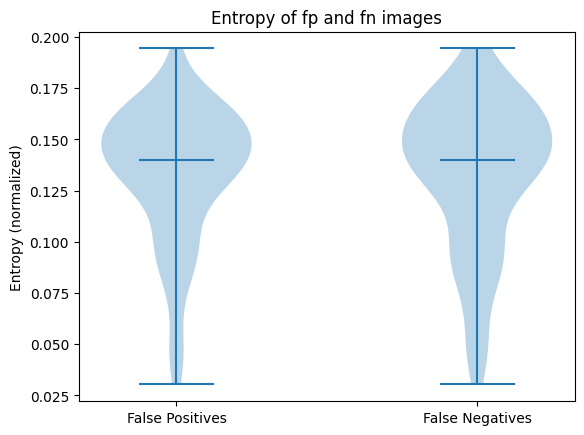

In [51]:
#violin plot of the entropy for fp and fn images
fig, ax = plt.subplots()
all_fp_indices = list(all_fp_indices)
all_fn_indices = list(all_fn_indices)
ax.violinplot([entropy_normalized[all_fp_indices], entropy_normalized[all_fn_indices]], showmedians=True, points=500)
ax.set_title('Entropy of fp and fn images')
ax.set_xticks([1, 2])
ax.set_xticklabels(['False Positives', 'False Negatives'])
ax.set_ylabel('Entropy (normalized)')

Number of completely correct images: 286


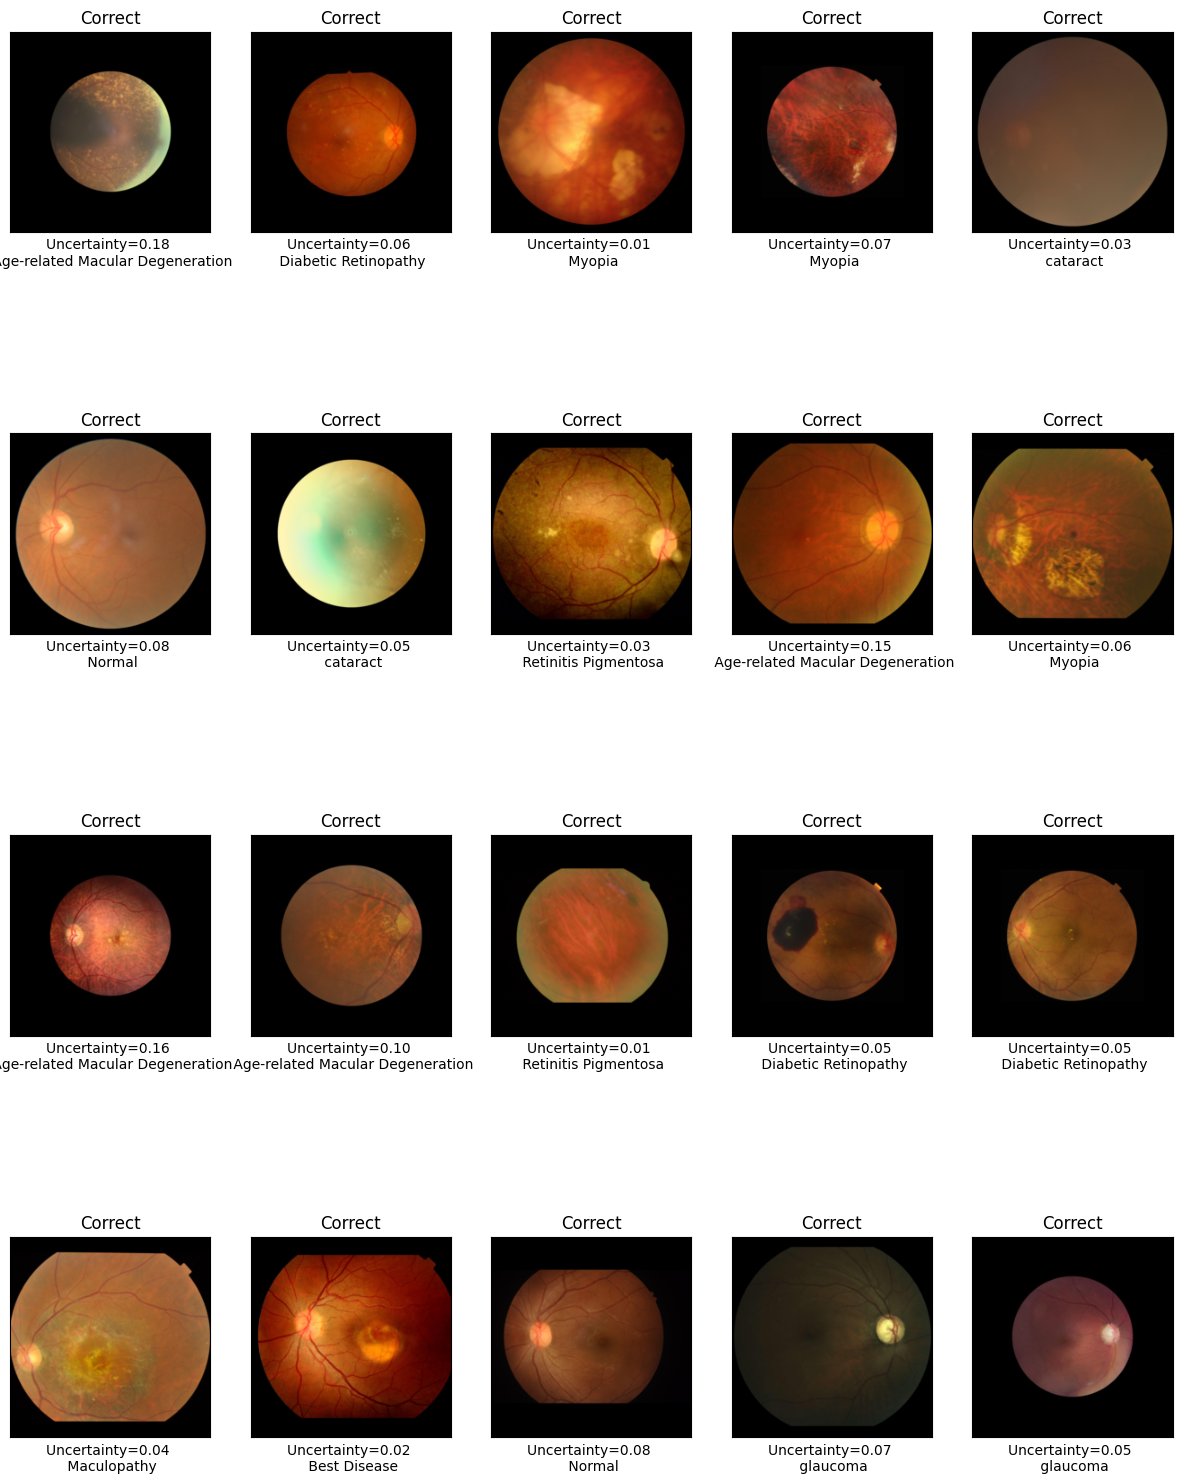

In [52]:
fn =torch.where((y_true == 1) & (y_pred_cm == 0))
#result show that tthe wrong predictions have an entropy which is very close to the median entropy or higher
# Replace this with your actual data
all_train_dataset_classes = train_dataset.classes
n_categories_per_class = 2
n_images = 20
n_images_per_row = 5
n_rows = n_images // n_images_per_row
y_pred_prob = torch.sigmoid(y_pred)
#find the indices of the images which are completely correct
correct_indices = torch.where((y_true == y_pred_cm).all(dim=1))[0]
print(f'Number of completely correct images: {len(correct_indices)}')
#sekect 5 random indices
selected_correct_indices = correct_indices[torch.randperm(len(correct_indices))[:n_images]].numpy()
#get the labels of the images
correct_predicted_labels = y_true[selected_correct_indices]

true_correct_labels = torch.where(correct_predicted_labels == 1)
#get the label names
correct_label_names = [all_train_dataset_classes[i] for i in true_correct_labels[1]]

#select the images and labels from the test set
correct_images = [test_dataset[i][0] for i in selected_correct_indices]
#split ax into 5 subplots
fig, axes = plt.subplots(n_rows, n_images_per_row, figsize=(15*(n_images_per_row//4) , 20*(n_images_per_row//4)))
axes = axes.flatten()
#turn off all axes ticks
#plot the images
for j, correct_image in enumerate(correct_images):
   
    axes[j].set_xticks([])
    axes[j].set_yticks([])
    axes[j].imshow(correct_image.permute(1, 2, 0))
    axes[j].set_title('Correct')
    #add probability of the image being in the class
    axes[j].set_xlabel(f'Uncertainty={entropy_normalized[selected_correct_indices[j]]:.2f} \n {correct_label_names[j]}')



#plt.tight_layout()
plt.show()

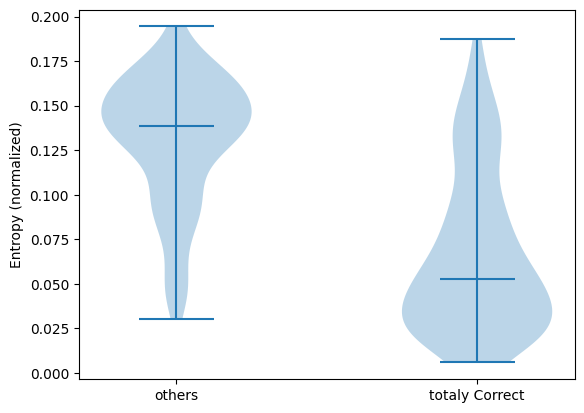

In [53]:


#plot the entropy for the predictions that are not completely correct and the ones that are
fig, ax = plt.subplots()
all_idxs = np.arange(len(y_true))
incorrect_indices = all_idxs[~np.isin(all_idxs, correct_indices)]
ax.violinplot([entropy_normalized[incorrect_indices], entropy_normalized[correct_indices]], showmedians=True, points=500)
ax.set_xticks([1, 2])
ax.set_xticklabels(['others', 'totaly Correct'])
ax.set_ylabel('Entropy (normalized)')
plt.show()